# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [6]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

# Edit these paths

In [7]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsitya/' # adjust to match location of this Dryad repo folder
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherencea/' # adjust to match location of this Dryad repo folder
shuffload_folder3 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/peakheights/' # adjust to match location of this Dryad repo folder
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder
engagement_folder = 'C:/Users/Python/Desktop/LocalData/Figure1S1S2/' # adjust to match Figure 1, S1, S2 output save_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/Figure2S3/' 

In [8]:
''' Get reward & lick data for sessions w/ neural data'''

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
 
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        #print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        #print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        #print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)            

In [9]:
''' Find & Save Number of Requested Rewards per Epoch per Session & Animal '''
#block array
blocksatiety = []
blockreq = []
blocktrialn = []

#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        d['altreqbytrial'] = requests[alt_idx]
        
        # append req rates from blocks into block req array len(4 x total sessions)
        blockreq = np.append(blockreq, np.mean(requests[rewarda_idx])) # block 1
        blockreq = np.append(blockreq, np.mean(requests[rewardb_idx])) # block 2
        blockreq = np.append(blockreq, np.mean(requests[alta_idx])) # block 3
        blockreq = np.append(blockreq, np.mean(requests[altb_idx])) # block 4   
        
        blocktrialn = np.append(blocktrialn, len(requests[rewarda_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[rewardb_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[alta_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[altb_idx]))
        
        # append reward counts from previous task block into block satiety array len(4 x total sessions)
        blocksatiety = np.append(blocksatiety, 0) #no rewards before block a for every animal
        blocksatiety = np.append(blocksatiety, np.sum(requests[rewarda_idx])) # count of rewards consumed before block b
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]))) # before alta
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]) + np.sum(requests[alta_idx]))) # beforealtb             
                          
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)

blocksatiety = np.asarray(blocksatiety)
blockreq = np.asarray(blockreq)
blocktrialn = np.asarray(blocktrialn)

In [10]:
''' Find & save indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded''' 

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        
        #define indices for first two quarters accounting for skipped trials
        start_idx = (np.where(trial >= 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        enda_idx = (np.where(trial <= 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
        endb_idx = (np.where(trial <= 139)[0][-1]).astype(int) # last index before alternation
        Aidx = np.arange(start_idx, enda_idx + 1, 1)
        Bidx = np.arange(enda_idx + 1, endb_idx + 1, 1)
        
        #find context A / B trials in alternation, removing skipped trials
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
               
        A_trials = np.where((left == 1))[0]
        A_trials = list(A_trials[A_trials >= 140])
        B_trials = np.where((left == 0))[0]
        B_trials = list(B_trials[B_trials >= 140])
    
        # Find skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []
            
        for n, t in enumerate(skippedtrials):
            if t in A_trials:
                A_trials.remove(t)
            elif t in B_trials:
                B_trials.remove(t)
    
        A_idx = []
        for t in A_trials:
            A_idx = np.append(A_idx, np.where(trial == t)[0])
            A_idx = A_idx.astype(int)
            
        B_idx = []
        for t in B_trials:
            B_idx = np.append(B_idx, np.where(trial == t)[0])
            B_idx = B_idx.astype(int)
            
        #save indices for session sections
        Aidx_file = 'Aidx_' + m + '_' + s +'.npy'
        Bidx_file = 'Bidx_' + m + '_' + s +'.npy'
        A_idx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_idx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx
        
        np.save(save_folder + Aidx_file, Aidx)
        np.save(save_folder + Bidx_file, Bidx)
        np.save(save_folder + A_idx_file, A_idx)
        np.save(save_folder + B_idx_file, B_idx)
        #print('saved relevant data indices for future use') 
        
        # get non-gain change A' and B' indices 
        gain = trialinfo['gain']
        
        A_ngidx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_ngidx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        #check if mouse reached gain period; if not append NaN to all arrays & continue 
        if len(gain) < 200:
            #print(str(m) + str(s) + ' did not reach gain change')
            
            d['A_ngidx'] = A_idx
            d['B_ngidx'] = B_idx
            
            np.save(save_folder + A_ngidx_file, A_idx)
            np.save(save_folder + B_ngidx_file, B_idx)
            
            continue 
            
        #get count of gain change trials in each context & select equal number of last Context A or B alt trials before gain
        gain_trials = np.where((gain == 0.7))[0]
        gain_trials = list(gain_trials)

        Agtrials = np.intersect1d(A_trials, np.asarray(gain_trials))
        Agtrials = list(np.sort(Agtrials.astype(int)))
        Bgtrials = np.intersect1d(B_trials, np.asarray(gain_trials))                   
        Bgtrials = list(np.sort(Bgtrials.astype(int)))
    
        #get indices of observations corresponding to the selected trials
        Agidx = []
        for t in Agtrials:
            Agidx = np.append(Agidx, np.where(trial == t)[0])
        Agidx = Agidx.astype(int)
            
        Bgidx = []
        for t in Bgtrials:
            Bgidx = np.append(Bgidx, np.where(trial == t)[0])
        Bgidx = Bgidx.astype(int)
        
        A_ngidx = np.setdiff1d(A_idx,Agidx).astype(int)
        B_ngidx = np.setdiff1d(B_idx,Bgidx).astype(int)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx
        
        np.save(save_folder + A_ngidx_file, A_ngidx)
        np.save(save_folder + B_ngidx_file, B_ngidx)
        #print('saved gain adjusted alternation idx')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Classify spatial cells using shuffle results OR skip to next section.

You'll only need to run this section only once in order to generate spatial cell booleans for these sessions.

In [14]:
''' Calculate & Save Spatial Coherence & Sparsity Scores for all Sessions '''

dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        total_time = max(post) - min(post)
        
        #delineate contexta 
        start_idx = (np.where(trial == 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        end_idx = (np.where(trial == 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
        A = Y[start_idx:end_idx, :]
        aposxfil = posx[start_idx:end_idx]
        
        #get smoothed FR & sparsity scores 
        asmoothFR, _, asmoothocc = ps.tuning_curve(aposxfil, A, dt, b = 2, l=2, smooth=True, SEM=False, occupancy=True)
        aFR, _ , _ = ps.tuning_curve(aposxfil, A, dt, b = 2, l=2, smooth=False, SEM=False, occupancy=True)      
        
        #calculate sparsity with smoothed FR in Context A
        sparsitya_scores = []
        totala_time = max(post[start_idx:end_idx]) - min(post[start_idx:end_idx])
        for i, c in enumerate(cell_IDs):
            meanFRsqr = np.square(np.mean(asmoothFR[:,i]))
            products = []
            for b in range(asmoothFR.shape[0]):
                binmeanFRsqr = np.square(asmoothFR[b,i])
                prob = asmoothocc[b,i]/totala_time
                prod = prob * binmeanFRsqr
                products = np.append(products,prod)
            asparsity = np.sum(products) / meanFRsqr
            sparsitya_scores = np.append(sparsitya_scores,asparsity)
        d['spatialasparsity'] = sparsitya_scores

        # calculate spatial tuning coherence score with non-smoothed FR in Context A
        spatialacoherence_scores = []
        for i, c in enumerate(cell_IDs):
            neighbors = get.find8adjacentElements(aFR[:,i])
            meanFR_neighbors = []
            for b in range(aFR.shape[0]):
                meanFR_neigh = np.mean(neighbors[b])
                meanFR_neighbors = np.append(meanFR_neighbors, meanFR_neigh)
            acoherence, _ = stats.pearsonr(aFR[:,i],meanFR_neighbors)
            if math.isnan(acoherence):
                spatialacoherence_scores = np.append(spatialacoherence_scores,0)
            else:
                spatialacoherence_scores = np.append(spatialacoherence_scores,acoherence)
        d['spatialacoherencescores'] = spatialacoherence_scores
    
        #Get file names & save scores as npy files
        sparsityascore_file = 'sparsityascores_' + m + '_' + s + '.npy'
        spatialacoherencescore_file = 'spatialacoherencescores_' + m + '_' + s + '.npy'    
        
        np.save(save_folder + sparsityascore_file, sparsitya_scores)
        #print('saved sparsity A scores as npy file for mouse ' + m + ' session '+ s)

        np.save(save_folder + spatialacoherencescore_file, spatialacoherence_scores)
        #print('saved spatial coherence A scores as npy file for mouse ' + m + ' session '+ s)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1988913492.py:44: RuntimeWarning: invalid value encountered in scalar divide
  asparsity = np.sum(products) / meanFRsqr


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
''' Load saved scores to classify spatial cells

Note : intn booleans are produced by the notebook "Shuffle Procedure..." Run the first part of that for all sessions before 
proceeding here.

'''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        shufsparsityascore_file = 'shufsparsityascores_' + m + '_' + s + '.npy'
        shufspatialacoherencescore_file = 'shufspatialacoherencescores_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load npy files       

        d['shuffsparsityascores'] = np.load(shuffload_folder1 + shufsparsityascore_file, allow_pickle=False)
        d['shuffspatialacoherencescores'] = np.load(shuffload_folder2 + shufspatialacoherencescore_file, allow_pickle=False)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        d['intn'] = d['intn'].astype(bool)

        try:
            _ = d['spatialasparsity'].shape
        except:
            print('loading previously generated sparsity & coherence scores...')
            sparsityascore_file = 'sparsityascores_' + m + '_' + s + '.npy'
            spatialacoherencescore_file = 'spatialacoherencescores_' + m + '_' + s + '.npy' 
            
            d['spatialasparsity'] = np.load(save_folder + sparsityascore_file, allow_pickle=True)
            d['spatialacoherencescores'] = np.load(save_folder + spatialacoherencescore_file, allow_pickle=True)

  0%|          | 0/3 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/4 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/4 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


In [12]:
''' Gather total number of SM cells'''

young_count = 0
MA_count = 0
age_count = 0

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        if m in SM_aged_mice:
            age_count += len(cell_IDs)
        elif m in SM_MA_mice:
            MA_count += len(cell_IDs)
        else:
            young_count += len(cell_IDs)
            
print(young_count, MA_count, age_count)

15152 15011 13225


In [13]:
''' Classify Spatial Cells at P95 from Context A Sparsity & Coherence '''

per95c = []
per95s = []
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores']
        shuffsparsityascores = d['shuffsparsityascores'] 
        shuffspatialacoherencescores = d['shuffspatialacoherencescores'] 
        intn = d['intn']

        #Classify spatial cells as those > P95 of both Contexte A shuffle sparsity & coherence score distributions
        spatialcell95 = []
        for i, c in enumerate(cell_IDs):

            dist1 = shuffspatialacoherencescores[:,i]
            P951 = np.nanpercentile(dist1,95)

            dist2 = shuffsparsityascores[:,i]
            P952 = np.nanpercentile(dist2,95)
            
            per95c.append(P951)
            per95s.append(P952)

            if intn[i] == True: #spatial cells must be excitatory
                spatialcell95 = np.append(spatialcell95, False)
            elif (spatialacoherence_scores[i] > P951) & (sparsitya_scores[i] > P952):
                spatialcell95 = np.append(spatialcell95, True)
            else:
                spatialcell95 = np.append(spatialcell95, False)
        spatialcell95 = np.asarray(spatialcell95).astype(bool)

        #save speed cell IDs in nested list for all animals
        d['spatialcell95'] = spatialcell95    
        #print('% spatial cells = ' + str(100*len(cell_IDs[spatialcell95])/len(cell_IDs)))
        
        spatialcell95_file = 'spatialcell95_' + m + '_' + s + '.npy'
        #np.save(save_folder + spatialcell95_file, spatialcell95)
        #print('saved spatial cell booleans as npy files for mouse ' + m + ' session '+ s)

print('\nMean ± SEM Coherence P95: ' + str(np.nanmean(per95c)) + ' ± ' + str(stats.sem(per95c, nan_policy = 'omit')))
print('Mean ± SEM Sparsity P95:' + str(np.nanmean(per95s)) + ' ± ' + str(stats.sem(per95s,  nan_policy = 'omit'))) 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Mean ± SEM Coherence P95: 0.3910526001251149 ± 0.0007825185327001357
Mean ± SEM Sparsity P95:1.4206468773988374 ± 0.012832039772898058


# Classify non-grid vs. grid cells or load classification.

In [11]:
''' If you skipped the section above, load spatial cell and intn booleans. '''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        spatialcell95_file = 'spatialcell95_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load stuff
        d['spatialcell95'] = np.load(save_folder + spatialcell95_file, allow_pickle = True)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [18]:
'''Classify grid vs. non-grid cells at P99 peak height threshold and with FR thresholds & save results.

Run time < 1 min / session (167 sessions). If you have preiously run this, skip ahead to the next cell to load results.

'''

track_length = 400 #cm
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20 #trials
lags = np.arange(0,801,1)

perngs = []
pergrid = []
for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        rawtrialfil = raw.item().get('trialfil')
        
        Aidx = d['Aidx']
        Bidx = d['Bidx']
        
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b= 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
        
        #load in spatial cells & interneurons classified elsewhere
        spatialcell95 = d['spatialcell95']
        spatialcells = cell_IDs[spatialcell95]
        intn = d['intn']
        
        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        peak = [] # boolean if peak found
        maxpeak_locs = [] #stored lag of max peak if peak exist
        maxpeak_heights = [] # stored height of max peak, otherwise 0 if not exist
        maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            autocorrelation = get.autocorr(FR[sdx,:], lags)
            normauto = autocorrelation / autocorrelation[0]
            peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
            proms = properties["prominences"]
            heights = properties["peak_heights"]

            if peaks.size > 0:
                peak = np.append(peak,1)
                maxpeak_locs = np.append(maxpeak_locs, peaks[np.argmax(proms)])
                maxpeak_heights = np.append(maxpeak_heights, heights[np.argmax(proms)])
                maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
            else:
                peak = np.append(peak,0)
                maxpeak_heights = np.append(maxpeak_heights,0)
                maxpeak_proms = np.append(maxpeak_proms,0)         
        peak = peak.astype(bool)
        
        #define low FR cell group (mean FR <0.05 in the dark; 0.3 Hz overall); to be removed from grid cell group
        stop_idx = np.where(trial <= 19)[0][-1].astype(int)
        darkFR, _ , _ = ps.tuning_curve_bytrial(posxfil[:stop_idx], trial[:stop_idx], Y[:stop_idx,:], dt, sigma = 2, b = 2, smooth=True, normalize=False, occupancy=True)
        FR, _, _ = ps.tuning_curve(posxfil, Y, dt, b=2, smooth=True, l=2, SEM=False, occupancy=False)
        lowfrcells = []
        lowdarkfrcells = []
        for i, c in enumerate(cell_IDs):
            if np.mean(np.mean(darkFR[:,:,i], axis = 1)) <= 0.05:
                lowdarkfrcells = np.append(lowdarkfrcells, c)
            elif np.mean(FR[:,i]) < 0.3:
                lowfrcells = np.append(lowfrcells, c)      
                
        #define indices excluding reward zone starts
        reward = raw.item().get('reward')
        centers = reward['centers']
        centera = centers[0]
        if centera == 270:
            centerb = 370
        else:
            centerb = 270
        
        # generate aligned position tuning curve
        aFR, abinned_pos, aFR_sem, occ = ps.tuning_curve(posxfil[Aidx], Y[Aidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        bFR, bbinned_pos, bFR_sem, occ = ps.tuning_curve(posxfil[Bidx], Y[Bidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        
        #find indices of bins not including 50cm pre-post reward centers (220 to 255 and 320 to 355)
        aidx = np.where((abinned_pos > (centera - 50)) & (abinned_pos <= (centera - 15)))
        maska = np.ones(len(abinned_pos), bool)
        maska[aidx] = 0
        bidx = np.where((bbinned_pos > (centerb - 50)) & (bbinned_pos <= (centerb - 15)))
        maskb = np.ones(len(bbinned_pos), bool)
        maskb[bidx] = 0
        
        noisycells = []
        for i, c in enumerate(cell_IDs):
            if (np.mean(aFR_sem[maska,i]) > np.mean(aFR[maska,i])*.45) and (np.mean(bFR_sem[maskb,i]) > np.mean(bFR[maskb,i])*.45):
                noisycells = np.append(noisycells, c)
        
        #classify grid cells based on peak prominence > P99 shuffle height
        shufmaxpeak_heights_file = 'shufmaxpeak_heights__' + m + '_' + s + '.npy'
        shuffmaxpeak_heights = np.load(shuffload_folder3 + shufmaxpeak_heights_file)
    
        gridcell = []
        for i, c in enumerate(cell_IDs):
            #require that grid cells have at least one peak larger than 0.15 prominence, height 0.1, width = 10 in the dark
            #also require that prom of peak exceeds P99 of shuffle autocorrelation height distribution autocorrelations at that same lag
            #also require that that cell is not an interneuron
    
            if (intn[i] == 0) & (peak[i] == 1):
                idx = np.where(cell_IDs[peak] == c)[0][0]
                dist = shuffmaxpeak_heights[:,idx]
                P99 = np.percentile(dist,99)
                P95 = np.percentile(dist,95)

                if (maxpeak_proms[i] >= P95):
                    gridcell = np.append(gridcell, 1)
                else:
                    gridcell = np.append(gridcell, 0)
            else: 
                gridcell = np.append(gridcell, 0)
                
        #Find non-distance coding spatial cells to be ngs cells; then further            
        ngscell = []
        for i, c in enumerate(cell_IDs):
            #ngs cells are any spatial cells that do not meet distance-coding cell criteria or meet that criteria with a
            #very low dark FR 
            if (intn[i] == 1) | (gridcell[i] == 1) | (spatialcell95[i] == 0):
                ngscell = np.append(ngscell, 0)
            elif (peak[i] == 1): #remove any low quality grid cells that have a peak 
                idx = np.where(cell_IDs[peak] == c)[0][0]
                P90 = np.percentile(dist, 90)
                
                if (maxpeak_proms[i] >= P90) & (maxpeak_proms[i] < P99):
                    ngscell = np.append(ngscell, 0)
                elif (intn[i] == 0) & (gridcell[i] == 0) & (spatialcell95[i] == 1): 
                    ngscell = np.append(ngscell, 1)
                else: 
                    ngsell = np.append(ngscell, 0)
            elif (c not in lowdarkfrcells) & (peak[i] == 0) & (intn[i] == 0) & (spatialcell95[i] == 1):
                ngscell = np.append(ngscell, 1)
            else: 
                ngscell = np.append(ngscell, 0)
                
        # filter out noisy cells from both grid and ngs cells and low firing grid cells    
        for i, c in enumerate(cell_IDs):
            #also require that dark FR > 0.05 Hz and mean FR > 0.3 Hz
            if (c in lowfrcells) or (c in lowdarkfrcells):
                gridcell[i] = 0
                
            if (c in noisycells):
                gridcell[i] = 0
                ngscell[i] = 0
                
        #Save booleans
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        d['gridcell'] = gridcell
        d['ngscell'] = ngscell
        
        #gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        #np.save(save_folder + gridcell_file, gridcell.astype(bool))
        #print('saved grid cell boolean for spatial cells as npy file for mouse ' + m + ' session '+ s)
                
        #ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        #np.save(save_folder + ngscell_file, d['ngscell'])
        #print('saved ngs cell boolean for spatial cells as npy file for mouse ' + m + ' session '+ s)

        #save percentages of grid vs. ngs cells
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n grid, ngs cells: 19 , 54
A14, 083122_record2 n grid, ngs cells: 51 , 5
A14, 090122_record3 n grid, ngs cells: 18 , 15


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 5 , 7
A15, 083122_record2 n grid, ngs cells: 90 , 34
A15, 090122_record3 n grid, ngs cells: 97 , 37
A15, 090222_record4 n grid, ngs cells: 150 , 71
A15, 090322_record5 n grid, ngs cells: 54 , 33
A15, 090422_record6 n grid, ngs cells: 28 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 25 , 25
A16, 083122_record2 n grid, ngs cells: 64 , 35
A16, 090122_record3 n grid, ngs cells: 0 , 2
A16, 090222_record4 n grid, ngs cells: 18 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 2 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 7
A17, 082522_record3 n grid, ngs cells: 46 , 40
A17, 082622_record4 n grid, ngs cells: 48 , 21
A17, 082722_record5 n grid, ngs cells: 46 , 22
A17, 082822_record6 n grid, ngs cells: 61 , 24


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 18 , 11
A18, 082422_record2 n grid, ngs cells: 100 , 151
A18, 082522_record3 n grid, ngs cells: 90 , 122
A18, 082622_record4 n grid, ngs cells: 58 , 78
A18, 082722_record5 n grid, ngs cells: 52 , 11
A18, 082822_record6 n grid, ngs cells: 0 , 34


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 27 , 1
A19, 012823_record3 n grid, ngs cells: 31 , 78
A19, 012923_record4 n grid, ngs cells: 52 , 69
A19, 013023_record5 n grid, ngs cells: 67 , 34
A19, 013123_record6 n grid, ngs cells: 46 , 18
A19, 020123_record7 n grid, ngs cells: 66 , 22


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 7 , 19
A20, 012723_record2 n grid, ngs cells: 36 , 45
A20, 012823_record3 n grid, ngs cells: 78 , 52
A20, 012923_record4 n grid, ngs cells: 28 , 44
A20, 013023_record5 n grid, ngs cells: 34 , 51
A20, 013123_record6 n grid, ngs cells: 12 , 34


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 64 , 34
A22, 013023_record3 n grid, ngs cells: 109 , 95
A22, 013123_record4 n grid, ngs cells: 64 , 43
A22, 020123_record5 n grid, ngs cells: 11 , 12
A22, 020223_record6 n grid, ngs cells: 40 , 34
A22, 020323_record7 n grid, ngs cells: 19 , 6


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 6 , 8
A23, 021023_record2 n grid, ngs cells: 35 , 63
A23, 021123_record3 n grid, ngs cells: 38 , 63
A23, 021223_record4 n grid, ngs cells: 13 , 4
A23, 021323_record5 n grid, ngs cells: 34 , 37
A23, 021423_record6 n grid, ngs cells: 58 , 52


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 49 , 37
A24, 022723_record2 n grid, ngs cells: 122 , 75
A24, 022823_record3 n grid, ngs cells: 71 , 61
A24, 030123_record4 n grid, ngs cells: 77 , 29
A24, 030223_record5 n grid, ngs cells: 58 , 27
A24, 030323_record6 n grid, ngs cells: 22 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 80 , 93
MA10F, 111422_record2 n grid, ngs cells: 71 , 41
MA10F, 111522_record3 n grid, ngs cells: 46 , 27
MA10F, 111622_record4 n grid, ngs cells: 27 , 23
MA10F, 111722_record5 n grid, ngs cells: 29 , 23
MA10F, 111822_record6 n grid, ngs cells: 54 , 76


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 36 , 23
MA1F, 102422_record2 n grid, ngs cells: 62 , 26
MA1F, 102522_record3 n grid, ngs cells: 56 , 22
MA1F, 102622_record4 n grid, ngs cells: 11 , 9
MA1F, 102722_record5 n grid, ngs cells: 85 , 46
MA1F, 102822_record6 n grid, ngs cells: 84 , 26


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 57 , 80
MA2F, 102422_record2 n grid, ngs cells: 53 , 94
MA2F, 102522_record3 n grid, ngs cells: 78 , 103
MA2F, 102622_record4 n grid, ngs cells: 49 , 63
MA2F, 102722_record5 n grid, ngs cells: 44 , 48
MA2F, 102822_record6 n grid, ngs cells: 54 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 11 , 20
MA3M, 102422_record2 n grid, ngs cells: 43 , 62
MA3M, 102522_record3 n grid, ngs cells: 43 , 56
MA3M, 102622_record4 n grid, ngs cells: 17 , 58
MA3M, 102722_record5 n grid, ngs cells: 18 , 30
MA3M, 102822_record6 n grid, ngs cells: 37 , 45


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 45 , 53
MA4M, 110122_record3 n grid, ngs cells: 32 , 25
MA4M, 110222_record4 n grid, ngs cells: 11 , 11
MA4M, 110322_record5rep n grid, ngs cells: 30 , 21
MA4M, 110422_record6 n grid, ngs cells: 51 , 40
MA4M, 110522_record7 n grid, ngs cells: 13 , 10


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 78 , 26
MA5M, 110722_record2 n grid, ngs cells: 74 , 61
MA5M, 110822_record3 n grid, ngs cells: 93 , 32
MA5M, 110922_record4 n grid, ngs cells: 11 , 13
MA5M, 111022_record5 n grid, ngs cells: 29 , 29
MA5M, 111122_record6 n grid, ngs cells: 29 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 38 , 78
MA6M, 103122_record2 n grid, ngs cells: 26 , 43
MA6M, 110122_record3 n grid, ngs cells: 84 , 55
MA6M, 110222_record4 n grid, ngs cells: 10 , 14
MA6M, 110322_record5 n grid, ngs cells: 15 , 7
MA6M, 110422_record6 n grid, ngs cells: 44 , 34


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 34 , 35
MA7M, 103122_record2 n grid, ngs cells: 45 , 49
MA7M, 110122_record3 n grid, ngs cells: 25 , 34
MA7M, 110222_record4 n grid, ngs cells: 11 , 8


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 22 , 7
MA8F, 111422_record2 n grid, ngs cells: 77 , 58
MA8F, 111522_record3 n grid, ngs cells: 86 , 29
MA8F, 111622_record4 n grid, ngs cells: 32 , 31
MA8F, 111722_record5 n grid, ngs cells: 20 , 23
MA8F, 111822_record6 n grid, ngs cells: 14 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 68 , 37
MA9F, 111422_record2 n grid, ngs cells: 97 , 171
MA9F, 111522_record3 n grid, ngs cells: 137 , 89
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 28 , 31
MA9F, 111822_record6 n grid, ngs cells: 28 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 13 , 5
Y20, 092622_record2 n grid, ngs cells: 39 , 32
Y20, 092722_record3 n grid, ngs cells: 15 , 14
Y20, 092822_record4 n grid, ngs cells: 58 , 32
Y20, 092922_record5 n grid, ngs cells: 23 , 11
Y20, 093022_record6 n grid, ngs cells: 98 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 116 , 68
Y21, 091922_record2 n grid, ngs cells: 105 , 105
Y21, 092022_record3 n grid, ngs cells: 61 , 29
Y21, 092122_record4 n grid, ngs cells: 72 , 61
Y21, 092222_record5 n grid, ngs cells: 58 , 51
Y21, 092322_record6 n grid, ngs cells: 12 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 93 , 53
Y22, 092622_record2 n grid, ngs cells: 163 , 57
Y22, 092722_record3 n grid, ngs cells: 75 , 91
Y22, 092822_record4 n grid, ngs cells: 27 , 24
Y22, 092922_record5 n grid, ngs cells: 23 , 27
Y22, 093022_record6 n grid, ngs cells: 67 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 48 , 25
Y23, 092622_record2 n grid, ngs cells: 35 , 27
Y23, 092722_record3 n grid, ngs cells: 41 , 44
Y23, 092822_record4 n grid, ngs cells: 31 , 30
Y23, 092922_record5 n grid, ngs cells: 43 , 53
Y23, 093022_record6 n grid, ngs cells: 72 , 81


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 103 , 66
Y24, 091922_record2 n grid, ngs cells: 43 , 76
Y24, 092022_record3 n grid, ngs cells: 101 , 58
Y24, 092122_record4 n grid, ngs cells: 106 , 59
Y24, 092222_record5 n grid, ngs cells: 74 , 48
Y24, 092322_record6 n grid, ngs cells: 79 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 95 , 45
Y25, 021823_record3 n grid, ngs cells: 46 , 68
Y25, 021923_record4 n grid, ngs cells: 52 , 58
Y25, 022023_record5 n grid, ngs cells: 62 , 50
Y25, 022123_record6 n grid, ngs cells: 29 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 42 , 43
Y26, 021723_record2 n grid, ngs cells: 67 , 22
Y26, 021823_record3 n grid, ngs cells: 25 , 30
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 20 , 20
Y26, 022123_record6 n grid, ngs cells: 6 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 59 , 46
Y27, 021723_record2 n grid, ngs cells: 43 , 18
Y27, 021823_record3 n grid, ngs cells: 37 , 20
Y27, 021923_record4 n grid, ngs cells: 22 , 19
Y27, 022023_record5rep n grid, ngs cells: 53 , 29
Y27, 022123_record6 n grid, ngs cells: 73 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 5 , 32
Y28, 022723_record2 n grid, ngs cells: 55 , 76
Y28, 022823_record3 n grid, ngs cells: 71 , 43
Y28, 030123_record4 n grid, ngs cells: 27 , 30
Y28, 030223_record5 n grid, ngs cells: 63 , 89
Y28, 030323_record6 n grid, ngs cells: 76 , 50


In [19]:
''' If you have previously classified grid & ngs cells, run this cell instead of the one above. 
Load saved grid & ngs cell booleans.

'''

pergrid = []
perngs = []

spergrid = []
sperngs = []
mpergrid = []

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #load all grid cell boolean
        #gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        #gridcell = np.load(save_folder + gridcell_file)
        
        #ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        #ngscell = np.load(save_folder + ngscell_file)
        
        gridcell = d['gridcell']
        ngscell = d['ngscell']
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))
        
        sperngs = np.append(sperngs, 100*np.sum(ngscell)/len(cell_IDs))
        spergrid = np.append(spergrid, 100*np.sum(gridcell)/len(cell_IDs))
        m_pergrid = np.append(m_pergrid, np.sum(gridcell))
        m_cells = np.append(m_cells, len(cell_IDs))
      
    mpergrid = np.append(mpergrid, np.sum(m_pergrid)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n grid, ngs cells: 19 , 54
A14, 083122_record2 n grid, ngs cells: 51 , 5
A14, 090122_record3 n grid, ngs cells: 18 , 15


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 5 , 7
A15, 083122_record2 n grid, ngs cells: 90 , 34
A15, 090122_record3 n grid, ngs cells: 97 , 37
A15, 090222_record4 n grid, ngs cells: 150 , 71
A15, 090322_record5 n grid, ngs cells: 54 , 33
A15, 090422_record6 n grid, ngs cells: 28 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 25 , 25
A16, 083122_record2 n grid, ngs cells: 64 , 35
A16, 090122_record3 n grid, ngs cells: 0 , 2
A16, 090222_record4 n grid, ngs cells: 18 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 2 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 7
A17, 082522_record3 n grid, ngs cells: 46 , 40
A17, 082622_record4 n grid, ngs cells: 48 , 21
A17, 082722_record5 n grid, ngs cells: 46 , 22
A17, 082822_record6 n grid, ngs cells: 61 , 24


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 18 , 11
A18, 082422_record2 n grid, ngs cells: 100 , 151
A18, 082522_record3 n grid, ngs cells: 90 , 122
A18, 082622_record4 n grid, ngs cells: 58 , 78
A18, 082722_record5 n grid, ngs cells: 52 , 11
A18, 082822_record6 n grid, ngs cells: 0 , 34


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 27 , 1
A19, 012823_record3 n grid, ngs cells: 31 , 78
A19, 012923_record4 n grid, ngs cells: 52 , 69
A19, 013023_record5 n grid, ngs cells: 67 , 34
A19, 013123_record6 n grid, ngs cells: 46 , 18
A19, 020123_record7 n grid, ngs cells: 66 , 22


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 7 , 19
A20, 012723_record2 n grid, ngs cells: 36 , 45
A20, 012823_record3 n grid, ngs cells: 78 , 52
A20, 012923_record4 n grid, ngs cells: 28 , 44
A20, 013023_record5 n grid, ngs cells: 34 , 51
A20, 013123_record6 n grid, ngs cells: 12 , 34


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 64 , 34
A22, 013023_record3 n grid, ngs cells: 109 , 95
A22, 013123_record4 n grid, ngs cells: 64 , 43
A22, 020123_record5 n grid, ngs cells: 11 , 12
A22, 020223_record6 n grid, ngs cells: 40 , 34
A22, 020323_record7 n grid, ngs cells: 19 , 6


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 6 , 8
A23, 021023_record2 n grid, ngs cells: 35 , 63
A23, 021123_record3 n grid, ngs cells: 38 , 63
A23, 021223_record4 n grid, ngs cells: 13 , 4
A23, 021323_record5 n grid, ngs cells: 34 , 37
A23, 021423_record6 n grid, ngs cells: 58 , 52


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 49 , 37
A24, 022723_record2 n grid, ngs cells: 122 , 75
A24, 022823_record3 n grid, ngs cells: 71 , 61
A24, 030123_record4 n grid, ngs cells: 77 , 29
A24, 030223_record5 n grid, ngs cells: 58 , 27
A24, 030323_record6 n grid, ngs cells: 22 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 80 , 93
MA10F, 111422_record2 n grid, ngs cells: 71 , 41
MA10F, 111522_record3 n grid, ngs cells: 46 , 27
MA10F, 111622_record4 n grid, ngs cells: 27 , 23
MA10F, 111722_record5 n grid, ngs cells: 29 , 23
MA10F, 111822_record6 n grid, ngs cells: 54 , 76


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 36 , 23
MA1F, 102422_record2 n grid, ngs cells: 62 , 26
MA1F, 102522_record3 n grid, ngs cells: 56 , 22
MA1F, 102622_record4 n grid, ngs cells: 11 , 9
MA1F, 102722_record5 n grid, ngs cells: 85 , 46
MA1F, 102822_record6 n grid, ngs cells: 84 , 26


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 57 , 80
MA2F, 102422_record2 n grid, ngs cells: 53 , 94
MA2F, 102522_record3 n grid, ngs cells: 78 , 103
MA2F, 102622_record4 n grid, ngs cells: 49 , 63
MA2F, 102722_record5 n grid, ngs cells: 44 , 48
MA2F, 102822_record6 n grid, ngs cells: 54 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 11 , 20
MA3M, 102422_record2 n grid, ngs cells: 43 , 62
MA3M, 102522_record3 n grid, ngs cells: 43 , 56
MA3M, 102622_record4 n grid, ngs cells: 17 , 58
MA3M, 102722_record5 n grid, ngs cells: 18 , 30
MA3M, 102822_record6 n grid, ngs cells: 37 , 45


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 45 , 53
MA4M, 110122_record3 n grid, ngs cells: 32 , 25
MA4M, 110222_record4 n grid, ngs cells: 11 , 11
MA4M, 110322_record5rep n grid, ngs cells: 30 , 21
MA4M, 110422_record6 n grid, ngs cells: 51 , 40
MA4M, 110522_record7 n grid, ngs cells: 13 , 10


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 78 , 26
MA5M, 110722_record2 n grid, ngs cells: 74 , 61
MA5M, 110822_record3 n grid, ngs cells: 93 , 32
MA5M, 110922_record4 n grid, ngs cells: 11 , 13
MA5M, 111022_record5 n grid, ngs cells: 29 , 29
MA5M, 111122_record6 n grid, ngs cells: 29 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 38 , 78
MA6M, 103122_record2 n grid, ngs cells: 26 , 43
MA6M, 110122_record3 n grid, ngs cells: 84 , 55
MA6M, 110222_record4 n grid, ngs cells: 10 , 14
MA6M, 110322_record5 n grid, ngs cells: 15 , 7
MA6M, 110422_record6 n grid, ngs cells: 44 , 34


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 34 , 35
MA7M, 103122_record2 n grid, ngs cells: 45 , 49
MA7M, 110122_record3 n grid, ngs cells: 25 , 34
MA7M, 110222_record4 n grid, ngs cells: 11 , 8


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 22 , 7
MA8F, 111422_record2 n grid, ngs cells: 77 , 58
MA8F, 111522_record3 n grid, ngs cells: 86 , 29
MA8F, 111622_record4 n grid, ngs cells: 32 , 31
MA8F, 111722_record5 n grid, ngs cells: 20 , 23
MA8F, 111822_record6 n grid, ngs cells: 14 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 68 , 37
MA9F, 111422_record2 n grid, ngs cells: 97 , 171
MA9F, 111522_record3 n grid, ngs cells: 137 , 89
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 28 , 31
MA9F, 111822_record6 n grid, ngs cells: 28 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 13 , 5
Y20, 092622_record2 n grid, ngs cells: 39 , 32
Y20, 092722_record3 n grid, ngs cells: 15 , 14
Y20, 092822_record4 n grid, ngs cells: 58 , 32
Y20, 092922_record5 n grid, ngs cells: 23 , 11
Y20, 093022_record6 n grid, ngs cells: 98 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 116 , 68
Y21, 091922_record2 n grid, ngs cells: 105 , 105
Y21, 092022_record3 n grid, ngs cells: 61 , 29
Y21, 092122_record4 n grid, ngs cells: 72 , 61
Y21, 092222_record5 n grid, ngs cells: 58 , 51
Y21, 092322_record6 n grid, ngs cells: 12 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 93 , 53
Y22, 092622_record2 n grid, ngs cells: 163 , 57
Y22, 092722_record3 n grid, ngs cells: 75 , 91
Y22, 092822_record4 n grid, ngs cells: 27 , 24
Y22, 092922_record5 n grid, ngs cells: 23 , 27
Y22, 093022_record6 n grid, ngs cells: 67 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 48 , 25
Y23, 092622_record2 n grid, ngs cells: 35 , 27
Y23, 092722_record3 n grid, ngs cells: 41 , 44
Y23, 092822_record4 n grid, ngs cells: 31 , 30
Y23, 092922_record5 n grid, ngs cells: 43 , 53
Y23, 093022_record6 n grid, ngs cells: 72 , 81


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 103 , 66
Y24, 091922_record2 n grid, ngs cells: 43 , 76
Y24, 092022_record3 n grid, ngs cells: 101 , 58
Y24, 092122_record4 n grid, ngs cells: 106 , 59
Y24, 092222_record5 n grid, ngs cells: 74 , 48
Y24, 092322_record6 n grid, ngs cells: 79 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 95 , 45
Y25, 021823_record3 n grid, ngs cells: 46 , 68
Y25, 021923_record4 n grid, ngs cells: 52 , 58
Y25, 022023_record5 n grid, ngs cells: 62 , 50
Y25, 022123_record6 n grid, ngs cells: 29 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 42 , 43
Y26, 021723_record2 n grid, ngs cells: 67 , 22
Y26, 021823_record3 n grid, ngs cells: 25 , 30
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 20 , 20
Y26, 022123_record6 n grid, ngs cells: 6 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 59 , 46
Y27, 021723_record2 n grid, ngs cells: 43 , 18
Y27, 021823_record3 n grid, ngs cells: 37 , 20
Y27, 021923_record4 n grid, ngs cells: 22 , 19
Y27, 022023_record5rep n grid, ngs cells: 53 , 29
Y27, 022123_record6 n grid, ngs cells: 73 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 5 , 32
Y28, 022723_record2 n grid, ngs cells: 55 , 76
Y28, 022823_record3 n grid, ngs cells: 71 , 43
Y28, 030123_record4 n grid, ngs cells: 27 , 30
Y28, 030223_record5 n grid, ngs cells: 63 , 89
Y28, 030323_record6 n grid, ngs cells: 76 , 50


In [74]:
''' If you have previously classified grid & ngs cells, run this cell instead of the one above. 
Load saved grid & ngs cell booleans.

'''

ygrid = 0
magrid = 0
agrid = 0

yngs = 0
mangs = 0
angs = 0 

for m, session in zip(mice,sessions):    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        gridcell = d['gridcell']
        ngscell = d['ngscell']
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        
        if m in SM_aged_mice:
            agrid += np.sum(gridcell)
            angs += np.sum(ngscell)
        elif m in SM_MA_mice:
            magrid += np.sum(gridcell)
            mangs += np.sum(ngscell)
        else:
            ygrid += np.sum(gridcell)
            yngs += np.sum(ngscell)
            
print(ygrid, magrid, agrid)
print(yngs, mangs, angs)

2924 2582 2516
2242 2354 2066


Mean, SEM Grid Cell %; Mean, Sem NGS Cell %
18.255296536199076 0.6597148834525249 15.324409157495849 0.5189048066071342


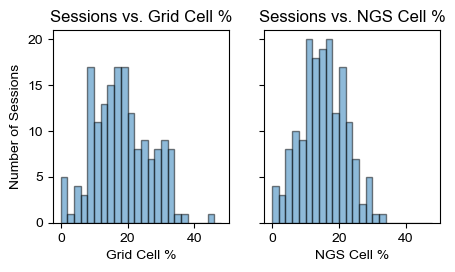

In [20]:
''' Examine grid & NGS cell densities quickly as a sanity check'''

# Assess distribution of grid/ngs cell densities
print('Mean, SEM Grid Cell %; Mean, Sem NGS Cell %')
print(np.mean(pergrid), stats.sem(pergrid), np.mean(perngs), stats.sem(perngs))

#plot grid vs. ngs cell % distributions
fig, ax = plt.subplots(1,2,figsize = (5,2.5), sharey = True)
ax[0].hist(pergrid, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[0].set_title('Sessions vs. Grid Cell %')
ax[0].set_ylabel('Number of Sessions')
ax[0].set_xlabel('Grid Cell %')

ax[1].hist(perngs, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[1].set_title('Sessions vs. NGS Cell %')
ax[1].set_xlabel('NGS Cell %')

plt.show()

In [21]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [22]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# set up handles
from itertools import repeat
per99 = [mpergrid[y_ind], mpergrid[ma_ind], mpergrid[age_ind]]
handles = []

for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        
        if c[0] == col_animal[0][0][8][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.append(l)

# Plot figures verifying classification of grid vs. ngs cells

Figure 2a-e & Figure S3a-h. Not required to run subsequent sections of this notebook.

  0%|          | 0/6 [00:00<?, ?it/s]

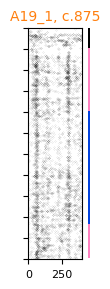

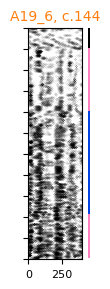

  0%|          | 0/6 [00:00<?, ?it/s]

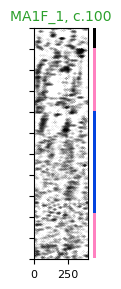

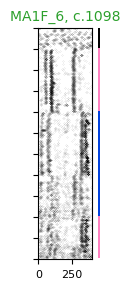

  0%|          | 0/6 [00:00<?, ?it/s]

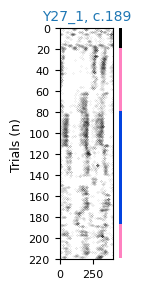

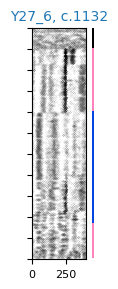

In [43]:
''' Sequentially Plot Example Grid Cell Rasters (Figure 2a)'''

switches = [-20, -80]
colors = ['xkcd:pink','xkcd:blue']
labels = ['Context A','Context B']
CLU_W = 3

from matplotlib.lines import Line2D
from copy import copy
count = 0
cellcount = 0

ex_mice = ['Y27','MA1F','A19'] # mouse names for Fig 2 / S3 examples
ex_sessions = ['021623_record1','022123_record6','102322_record1','102822_record6',
               '012723_record2','020123_record7'] #list of sssions

ex_gridcells = [875,144,100,1098,189,1132]
minimalistbool = [True,True,True,True,False,True]
sesh = [1,6,1,6,1,6]
cols = ['C1','C1','C2','C2','C0','C0']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue 
            
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posx = behaviorfil[:,0]
        reward = raw.item().get('reward')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        rawtrialfil = raw.item().get('trialfil')
        trial = behaviorfil[:,2]
    
        # Find skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []

        trials = np.unique(trial)
        alltrial = np.arange(0, 220 ,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
        context = []
        for i, t in enumerate(np.unique(skippedrawtrialfil)):
            if t < 220:
                context = np.append(context, leftsort[t.astype(int)])

        #Reverse y-axis
        skippedrawtrialfil = -1 * skippedrawtrialfil
        newskippedtrials = -1 * newskippedtrials

        ## PLOT RASTER w/ CONTEXT LABEL
        c = ex_gridcells[cellcount]
        minimalist = minimalistbool[cellcount]
        col = cols[cellcount]
        
        widths = [20,1]
        heights = [1]
        fig = plt.figure(figsize = (0.8,3))
        gs = gridspec.GridSpec(ncols = 2, nrows = 1, figure=fig, height_ratios = heights, width_ratios = widths)

        sdx = Z[:, np.where(cell_IDs == c)[0][0]].astype(bool)
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(posxcopy[sdx], skippedrawtrialfil[sdx], '.', color = 'k', markersize=0.2, alpha=0.4)
        ax1.set_xlim([0, 400])
        ax1.set_ylim([np.min(skippedrawtrialfil),0])
        ax1.set_yticks([-220,-200,-180,-160,-140,-120,-100,-80,-60,-40,-20,0])
        ax1.set_yticklabels([220,200,180,160,140,120,100,80,60,40,20,0])
        ax1.tick_params(labelsize = 8)
        ax1.set_title(str(m) + '_' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 10, color = col)

        if minimalist == False:
            ax1.set_ylabel('Trials (n)', fontsize = 9)
        else:
            ax1.set_yticklabels([])

        #label skipped trials for transparency
        for z in newskippedtrials:
            ax1.hlines(z,0,400, color = 'lightgrey', linewidth = 0.5, linestyles = 'dotted')

        #label dark trials & trial context at right
        ax2 = fig.add_subplot(gs[1], sharey = ax1)
        for i, t in enumerate(context.astype(bool)):
            if i >= 20:
                if i in newskippedtrials:
                    ax2.vlines(0, -1*i, -1*i + 1, colors='lightgrey', lw= CLU_W, linestyles= 'solid', alpha = 1)
                else:
                    if t == True:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:pink', lw= CLU_W, linestyles= 'solid', alpha = 1)
                    else:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:blue', lw= CLU_W, linestyles='solid', alpha = 1)
            else: 
                ax2.vlines(0, -1*i, -1*i + 1, colors='k', lw= CLU_W, linestyles='solid', alpha = 1)

        ax2.axis('off') 
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '2A.png', dpi = 400)
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '2A.svg', dpi = 400)
        plt.show()
        
        cellcount += 1

  0%|          | 0/6 [00:00<?, ?it/s]

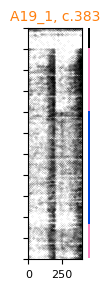

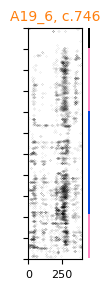

  0%|          | 0/6 [00:00<?, ?it/s]

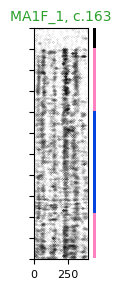

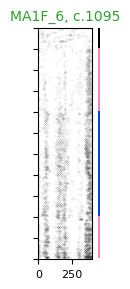

  0%|          | 0/6 [00:00<?, ?it/s]

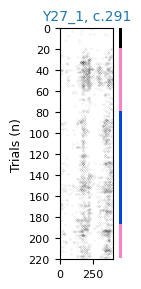

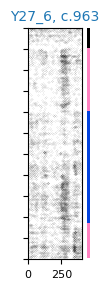

In [45]:
''' Sequentially Plot Example Non-Grid Spatial Cell Rasters (Figure S3a)'''

switches = [-20, -80]
colors = ['xkcd:pink','xkcd:blue']
labels = ['Context A','Context B']
CLU_W = 3

from matplotlib.lines import Line2D
from copy import copy
count = 0
cellcount = 0

ex_mice = ['Y27','MA1F','A19'] # mouse names for Fig 2 / S3 examples
ex_sessions = ['021623_record1','022123_record6','102322_record1','102822_record6',
               '012723_record2','020123_record7'] #list of sssions

ex_ngscells = [383,746,163,1095,291,963]
minimalistbool = [True,True,True,True,False,True]
sesh = [1,6,1,6,1,6]
cols = ['C1','C1','C2','C2','C0','C0']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue 
            
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posx = behaviorfil[:,0]
        reward = raw.item().get('reward')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        rawtrialfil = raw.item().get('trialfil')
        trial = behaviorfil[:,2]
    
        # Find skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []

        trials = np.unique(trial)
        alltrial = np.arange(0, 220 ,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
        context = []
        for i, t in enumerate(np.unique(skippedrawtrialfil)):
            if t < 220:
                context = np.append(context, leftsort[t.astype(int)])

        #Reverse y-axis
        skippedrawtrialfil = -1 * skippedrawtrialfil
        newskippedtrials = -1 * newskippedtrials

        ## PLOT RASTER w/ CONTEXT LABEL
        c = ex_ngscells[cellcount]
        minimalist = minimalistbool[cellcount]
        col = cols[cellcount]
        
        widths = [20,1]
        heights = [1]
        fig = plt.figure(figsize = (0.8,3))
        gs = gridspec.GridSpec(ncols = 2, nrows = 1, figure=fig, height_ratios = heights, width_ratios = widths)

        sdx = Z[:, np.where(cell_IDs == c)[0][0]].astype(bool)
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(posxcopy[sdx], skippedrawtrialfil[sdx], '.', color = 'k', markersize=0.2, alpha=0.4)
        ax1.set_xlim([0, 400])
        ax1.set_ylim([np.min(skippedrawtrialfil),0])
        ax1.set_yticks([-220,-200,-180,-160,-140,-120,-100,-80,-60,-40,-20,0])
        ax1.set_yticklabels([220,200,180,160,140,120,100,80,60,40,20,0])
        ax1.tick_params(labelsize = 8)
        ax1.set_title(str(m) + '_' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 10, color = col)

        if minimalist == False:
            ax1.set_ylabel('Trials (n)', fontsize = 9)
        else:
            ax1.set_yticklabels([])

        #label skipped trials for transparency
        for z in newskippedtrials:
            ax1.hlines(z,0,400, color = 'lightgrey', linewidth = 0.5, linestyles = 'dotted')

        #label dark trials & trial context at right
        ax2 = fig.add_subplot(gs[1], sharey = ax1)
        for i, t in enumerate(context.astype(bool)):
            if i >= 20:
                if i in newskippedtrials:
                    ax2.vlines(0, -1*i, -1*i + 1, colors='lightgrey', lw= CLU_W, linestyles= 'solid', alpha = 1)
                else:
                    if t == True:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:pink', lw= CLU_W, linestyles= 'solid', alpha = 1)
                    else:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:blue', lw= CLU_W, linestyles='solid', alpha = 1)
            else: 
                ax2.vlines(0, -1*i, -1*i + 1, colors='k', lw= CLU_W, linestyles='solid', alpha = 1)

        ax2.axis('off') 
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + 'S3A.png', dpi = 400)
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + 'S3A.svg', dpi = 400)
        plt.show()
        
        cellcount += 1

  0%|          | 0/6 [00:00<?, ?it/s]

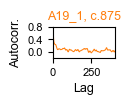

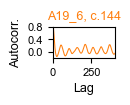

  0%|          | 0/6 [00:00<?, ?it/s]

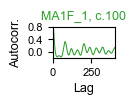

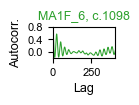

  0%|          | 0/6 [00:00<?, ?it/s]

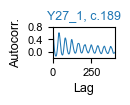

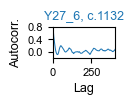

In [29]:
''' Plot dark FR autocorrelation of example grid cells (Figure 2b)'''

cellcount = 0

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        d = data[m][s]
    
        if s not in ex_sessions:
            continue 
            
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        cell_IDs = raw.item().get('cellsfil')

        #get stuff you will need later to shuffle & re-filter spike times to confirm putative grid spatial cells
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        rawspeed = raw.item().get('speed')

        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)

        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

        if m in SM_aged_mice:
            col = 'C1'
        elif m in SM_MA_mice:
            col = 'C2'
        else:
            col = 'C0'

        # for example cell, calc autocorrelation & plot
        c = ex_gridcells[cellcount]
        col = cols[cellcount]
        sdx = np.where(cell_IDs == c)[0][0]
        autocorrelation = get.autocorr(FR[sdx,:],lags)
        normauto = autocorrelation / autocorrelation[0]

        fig,ax = plt.subplots(figsize = (0.8,0.4))
        ax.plot(lags, normauto, color = col, linewidth = 0.75)
        ax.set_title(str(m) + '_' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 9, color = col)
        ax.set_xlabel('Lag',fontsize = 9)
        ax.set_ylabel('Autocorr.',fontsize = 9)
        ax.set_xlim([0,400])
        ax.set_ylim([-0.2, 0.8])
        ax.set_yticks([0, 0.4, 0.8])
        ax.tick_params(labelsize = 8)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + '2B.png', dpi = 400)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + '2B.svg', dpi = 400)
        plt.show()

        cellcount += 1    

  0%|          | 0/6 [00:00<?, ?it/s]

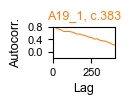

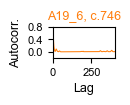

  0%|          | 0/6 [00:00<?, ?it/s]

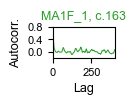

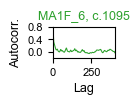

  0%|          | 0/6 [00:00<?, ?it/s]

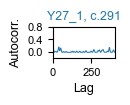

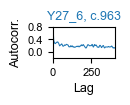

In [30]:
''' Plot dark FR autocorrelation of example non-grid spatial cells (Figure S3b)'''

cellcount = 0

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        d = data[m][s]
    
        if s not in ex_sessions:
            continue 
            
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        cell_IDs = raw.item().get('cellsfil')

        #get stuff you will need later to shuffle & re-filter spike times to confirm putative grid spatial cells
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        rawspeed = raw.item().get('speed')

        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)

        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

        if m in SM_aged_mice:
            col = 'C1'
        elif m in SM_MA_mice:
            col = 'C2'
        else:
            col = 'C0'

        # for example cell, calc autocorrelation & plot
        c = ex_ngscells[cellcount]
        col = cols[cellcount]
        sdx = np.where(cell_IDs == c)[0][0]
        autocorrelation = get.autocorr(FR[sdx,:],lags)
        normauto = autocorrelation / autocorrelation[0]

        fig, ax = plt.subplots(figsize = (0.8,0.4))
        ax.plot(lags, normauto, color = col, linewidth = 0.75)
        ax.set_title(str(m) + '_' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 9, color = col)
        ax.set_xlabel('Lag',fontsize = 9)
        ax.set_ylabel('Autocorr.',fontsize = 9)
        ax.set_xlim([0,400])
        ax.set_ylim([-0.2, 0.8])
        ax.set_yticks([0, 0.4, 0.8])
        ax.tick_params(labelsize = 8)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + 'S3B.png', dpi = 400)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + 'S3B.svg', dpi = 400)
        plt.show()

        cellcount += 1    

In [47]:
''' Choose a random shuffle rep vs. real distribution of all grid & non-grid cell autocorrelation peak heights

Run time <30s / session.

'''

import random

ngsshuffheights = []
gridshuffheights = []

gridproms = []
ngsproms = []
gridheights = []
ngsheights = []

P99shuffheight = []

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        cell_IDs = raw.item().get('cellsfil')
        
        #get stuff you will need later to shuffle & re-filter spike times to confirm putative grid spatial cells
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        rawspeed = raw.item().get('speed')
        
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
        
        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        peak = [] # boolean if peak found
        maxpeak_locs = [] #stored lag of max peak if peak exist
        maxpeak_heights = [] # stored height of max peak, otherwise 0 if not exist
        maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            autocorrelation = get.autocorr(FR[sdx,:],lags)
            normauto = autocorrelation / autocorrelation[0]
            peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
            proms = properties["prominences"]
            heights = properties["peak_heights"]

            if peaks.size > 0:
                peak = np.append(peak,1)
                maxpeak_locs = np.append(maxpeak_locs, peaks[np.argmax(proms)])
                maxpeak_heights = np.append(maxpeak_heights, heights[np.argmax(proms)])
                maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
            else:
                peak = np.append(peak,0)
                maxpeak_heights = np.append(maxpeak_heights,0)
                maxpeak_proms = np.append(maxpeak_proms,0)
                
        peak = peak.astype(bool)
    
        spatialcell95 = d['spatialcell95']
        spatialcells = cell_IDs[spatialcell95]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]  
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        
        shufmaxpeak_heights_file = 'shufmaxpeak_heights__' + m + '_' + s + '.npy'
        shuffmaxpeak_heights = np.load(shuffload_folder3 + shufmaxpeak_heights_file)
        
        for i, c in enumerate(cell_IDs):
            idx = np.where(cell_IDs[peak] == c)[0]
            
            if len(idx) == 0:
                P99shuffheight = np.append(P99shuffheight, np.nan)
            else:
                shuffheightP99 = np.percentile(np.ravel(shuffmaxpeak_heights[:,idx]), 99)
                P99shuffheight = np.append(P99shuffheight, shuffheightP99)

        for i, c in enumerate(gridcells):
            idx = np.where(cell_IDs[peak] == c)[0]
            sdx = np.where(cell_IDs == c)[0]
        
            shuffheight = np.random.choice(np.ravel(shuffmaxpeak_heights[:,idx]))
            gridproms = np.append(gridproms, maxpeak_proms[sdx])
            gridheights = np.append(gridheights, maxpeak_heights[sdx])
            gridshuffheights = np.append(gridshuffheights, shuffheight)
            
        for i, c in enumerate(ngscells):
            idx = np.where(cell_IDs[peak] == c)[0]
            sdx = np.where(cell_IDs == c)[0]
            
            if len(idx) > 0:
                shuffheight = np.random.choice(np.ravel(shuffmaxpeak_heights[:,idx]))
            else:
                shuffheight = 0
                
            ngsproms = np.append(ngsproms, maxpeak_proms[sdx])
            ngsheights = np.append(ngsheights, maxpeak_heights[sdx])
            ngsshuffheights = np.append(ngsshuffheights, shuffheight)

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Python\Desktop\GitHub\Herber2024\pipeline\get_data.py:380: RuntimeWarning: invalid value encountered in divide
  corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [48]:
''' Peak Height Thresholds & n model pairs vs. shuffle'''

print('n total cells w/ peaks: ' + str(len(P99shuffheight[~np.isnan(P99shuffheight)])))
print('% total cells w/ significant peaks: ' + str(100*len(P99shuffheight[~np.isnan(P99shuffheight)])/43388))

print('mean ± SEM coherence shuffle P99: ' + str(np.nanmean(P99shuffheight)) + ', ' + str(stats.sem(P99shuffheight, nan_policy = 'omit')))
print('n grid, NGS model pairs: ' + str(len(gridheights)) + ', ' + str(len(ngsheights)))

n total cells w/ peaks: 17498
% total cells w/ significant peaks: 40.329123259887524
mean ± SEM coherence shuffle P99: 0.2017224122142725, 0.0009507379791441329
n grid, NGS model pairs: 6508, 6559


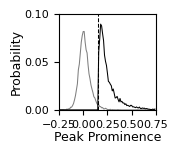

Mean, SEM Real:
0.2534256169200522 0.001305304064766415

Mean, SEM Shuffle:
0.009480445620091277 0.0007597516920575883

stat = 1598.0
p_cells = 0.0


In [49]:
'''Plot Figure 2c + Display Stats'''
bins = np.arange(-0.25,0.75,0.01)
gproms, bin_edges = np.histogram(gridproms, bins = bins)
pdf = gproms / sum(gproms)

shuffgheights, shuffbin_edges = np.histogram(gridshuffheights, bins = bins)
shuffpdf = shuffgheights / sum(shuffgheights)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.vlines(0.15,0,0.75, colors ='k', linewidths = 0.75, linestyles = '--')
ax.set_ylabel('Probability', fontsize = 9, labelpad = 1)
ax.set_xlabel('Peak Prominence', fontsize = 9, labelpad = 1)
ax.set_xlim([-0.25,0.75])
ax.set_xticks([-0.25,0,0.25,0.5,0.75])
ax.set_ylim([0, 0.10])
ax.set_yticks([0, 0.05,0.10])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + '2C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2C.svg', dpi=400, bbox_inches='tight')
plt.show()

print('Mean, SEM Real:')
print(np.nanmean(gridproms), stats.sem(gridproms, nan_policy = 'omit')) 
print('\nMean, SEM Shuffle:')
print(np.nanmean(gridshuffheights), stats.sem(gridshuffheights, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(gridproms, gridshuffheights)
print('\nstat = ' + str(stat))
print('p_cells = ' + str(p_diff))

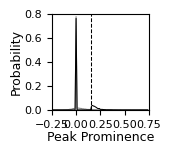

Mean, SEM Real:
0.0472958240195668 0.001072784178337035

Mean, SEM Shuffle:
0.011687197620582191 0.0006864173593978117

stat = 56304.0
p_cells = 2.868830085726912e-214


In [50]:
''' Plot Figure S3c'''
bproms, bin_edges = np.histogram(ngsproms, bins = bins)
pdf = bproms / sum(bproms)

shuffbheights, shuffbin_edges = np.histogram(ngsshuffheights, bins = bins)
shuffpdf = shuffbheights / sum(shuffbheights)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9, labelpad = 1)
ax.set_xlabel('Peak Prominence', fontsize = 9, labelpad = 1)
ax.vlines(0.15,0,0.8, colors ='k', linewidths = 0.75, linestyles = '--')
ax.set_xlim([-0.25,0.75])
ax.set_xticks([-0.25,0,0.25,0.5,0.75])
ax.set_ylim([0, 0.8])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'S3C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3C.svg', dpi=400, bbox_inches='tight')
plt.show()

print('Mean, SEM Real:')
print(np.nanmean(ngsproms), stats.sem(ngsproms, nan_policy = 'omit')) 
print('\nMean, SEM Shuffle:')
print(np.nanmean(ngsshuffheights), stats.sem(ngsshuffheights, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(ngsproms[~np.isnan(ngsshuffheights)], ngsshuffheights[~np.isnan(ngsshuffheights)])
print('\nstat = ' + str(stat))
print('p_cells = ' + str(p_diff))

In [51]:
'''Calculate Spatial Cell Type Density by Age Group'''
dt = 0.02

# set up arrays for plotting by session 
spergrid = [] 
sperngs = []

# by animal
mpergrid = [] 
mperngs = []

for m, session in zip(mice,sessions):
    
    m_grid = [] 
    m_ngs = []
    m_cells = []

    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #get cell IDs, filtered behavioral/spike data, & relevant score
        gridcell = d['gridcell'].astype(bool)
        ngscell = d['ngscell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscells = cell_IDs[ngscell]
        
        #Calculate Cell Densities
        sperngs = np.append(sperngs, 100 * len(ngscells)/len(cell_IDs))
        spergrid = np.append(spergrid, 100 * len(gridcells)/len(cell_IDs))

        #save data to be pooled by mouse    
        m_grid = np.append(m_grid, len(gridcells)) 
        m_ngs = np.append(m_ngs, len(ngscells)) 
        m_cells = np.append(m_cells, len(cell_IDs))
       
    # pool data by animal     
    mpergrid = np.append(mpergrid, 100*np.sum(m_grid)/np.sum(m_cells)) 
    mperngs = np.append(mperngs, 100*np.sum(m_ngs)/np.sum(m_cells)) 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

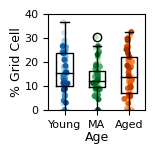


GRID CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
16.17 ± 1.14 ; 13.38 ± 0.79 ; 15.05 ± 1.24
F = 2.5862538000415984
p_grid%session = 0.27441138320138


In [52]:
'''Grid Cell Density Young vs. Aged Session by Age Group (Figure 2d) + Stats '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
pergrid = [spergrid[y_sind],spergrid[ma_sind],spergrid[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(pergrid, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Grid Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Grid Cell', fontsize=9, labelpad=1)
ax.set_ylim([0,40])
ax.tick_params(labelsize = 8)

for i in range(len(pergrid)):
    y = pergrid[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '2D.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2D.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nGRID CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(spergrid[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergrid[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergrid[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid[age_sind]), 2)))

stat, p_diff = stats.kruskal(spergrid[y_sind],spergrid[ma_sind],spergrid[age_sind])
print('F = ' + str(stat))
print('p_grid%session = ' + str(p_diff))

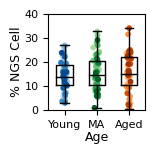


NGS CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
14.59 ± 0.87 ; 15.73 ± 0.95 ; 15.14 ± 1.08
F = 0.4809290162273214
p_ngs%session = 0.7862625508939945


In [53]:
'''NGS Cell Density Young vs. Aged Session by Age Group (Figure S3d) + Stats'''

fig, ax = plt.subplots(figsize = (1.25,1.25))
pergrid = [sperngs[y_sind],sperngs[ma_sind],sperngs[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(pergrid, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% NGS Cell', fontsize=9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,40])

for i in range(len(pergrid)):
    y = pergrid[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'S3D.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3D.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nNGS CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(sperngs[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngs[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngs[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngs[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngs[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngs[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperngs[y_sind],sperngs[ma_sind],sperngs[age_sind])
print('F = ' + str(stat))
print('p_ngs%session = ' + str(p_diff))

  0%|          | 0/6 [00:00<?, ?it/s]

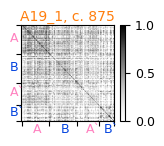

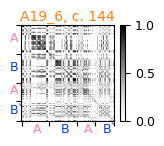

  0%|          | 0/6 [00:00<?, ?it/s]

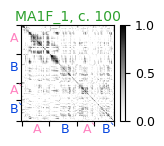

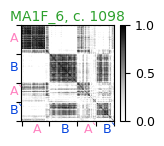

  0%|          | 0/6 [00:00<?, ?it/s]

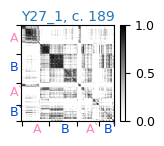

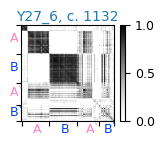

In [54]:
''' Plot example grid cell cross trial correlation matrices (Figure 2e) '''

cellcount = 0

colors = ['xkcd:pink','xkcd:blue','xkcd:pink', 'xkcd:blue']
labels = ['A', 'B','A`','B`']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue

        d = data[m][s]
    
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        spatialcell95 = d['spatialcell95']
        spatialcells = cell_IDs[spatialcell95]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]    

        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        rawtrialfil = raw.item().get('trialfil')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']

        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []

        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        # add ticks to label contexts dynamically
        lengthdark = (20 - ndarkskipped)
        lengthA = len(numtrial[numtrial < (80 - lengthdark)])
        nA_ = np.sum(1 - leftsort[alltrial >= 140])
        lengthB = len(numtrial[(numtrial >= (80 - lengthdark)) & (numtrial < (140 - lengthdark))])
        lengthA_ = len(numtrial[(numtrial >= (140 - lengthdark)) & (numtrial < (140 + nA_ - lengthdark))])
        end =  len(np.unique(skippedrawtrialfil[:end_idx])) - lengthdark
        nB_ = end - (lengthA + lengthB + lengthA_) 
        
        ticks = np.array([0, lengthA, (lengthA + lengthB), (lengthA + lengthB + lengthA_), end])
        textloc = np.array([lengthA // 2, (lengthA + lengthB // 2), (lengthA + lengthB + lengthA_//2), (lengthA + lengthB + lengthA_ + nB_//2)])

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        c = ex_gridcells[cellcount]
        col = cols[cellcount]
        sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
        sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 

        f = plt.figure(figsize=(1.5, 1.25))
        ax0 = plt.subplot()
        im = ax0.imshow(sim, clim=[0, 1.0], aspect='auto', cmap='Greys')
        ax0.set_title('{}_{}, c. {}'.format(m, sesh[cellcount], c), fontsize=10, color = col, pad=3)
        ax0.set_yticks(ticks, labels = [])
        ax0.set_xticks(ticks, labels = [])
        for n, j in enumerate(labels):
            ax0.text(textloc[n] - 5, 225, j, color = colors[n], fontsize = 9)
            ax0.text(-25, textloc[n] + 5, j, color = colors[n], fontsize = 9)
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize = 9)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_2E.png', dpi = 400)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_2E.svg', dpi = 400)
        plt.show()
        
        cellcount += 1 
                                    

  0%|          | 0/6 [00:00<?, ?it/s]

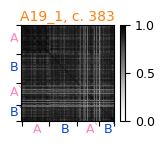

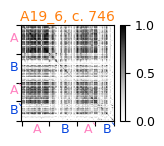

  0%|          | 0/6 [00:00<?, ?it/s]

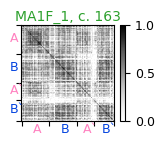

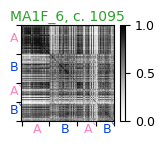

  0%|          | 0/6 [00:00<?, ?it/s]

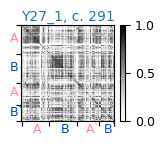

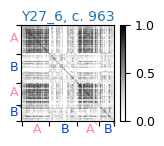

In [55]:
''' Plot example NGS cell cross trial correlation matrices (Figure S3e) '''

cellcount = 0

colors = ['xkcd:pink','xkcd:blue','xkcd:pink', 'xkcd:blue']
labels = ['A', 'B','A`','B`']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue

        d = data[m][s]
    
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        spatialcell95 = d['spatialcell95']
        spatialcells = cell_IDs[spatialcell95]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]    

        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        rawtrialfil = raw.item().get('trialfil')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']

        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []

        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        # add ticks to label contexts dynamically
        lengthdark = (20 - ndarkskipped)
        lengthA = len(numtrial[numtrial < (80 - lengthdark)])
        nA_ = np.sum(1 - leftsort[alltrial >= 140])
        lengthB = len(numtrial[(numtrial >= (80 - lengthdark)) & (numtrial < (140 - lengthdark))])
        lengthA_ = len(numtrial[(numtrial >= (140 - lengthdark)) & (numtrial < (140 + nA_ - lengthdark))])
        end =  len(np.unique(skippedrawtrialfil[:end_idx])) - lengthdark
        nB_ = end - (lengthA + lengthB + lengthA_) 
        
        ticks = np.array([0, lengthA, (lengthA + lengthB), (lengthA + lengthB + lengthA_), end])
        textloc = np.array([lengthA // 2, (lengthA + lengthB // 2), (lengthA + lengthB + lengthA_//2), (lengthA + lengthB + lengthA_ + nB_//2)])

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        c = ex_ngscells[cellcount]
        col = cols[cellcount]
        sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
        sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 

        f = plt.figure(figsize=(1.5, 1.25))
        ax0 = plt.subplot()
        im = ax0.imshow(sim, clim=[0, 1.0], aspect='auto', cmap='Greys')
        ax0.set_title('{}_{}, c. {}'.format(m,sesh[cellcount],c), fontsize=10, color = col, pad=3)
        ax0.set_yticks(ticks, labels = [])
        ax0.set_xticks(ticks, labels = [])
        for n, j in enumerate(labels):
            ax0.text(textloc[n] - 5, 225, j, color = colors[n], fontsize = 9)
            ax0.text(-25, textloc[n] + 5, j, color = colors[n], fontsize = 9)
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize = 9)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_S3E.png', dpi = 400)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_S3E.svg', dpi = 400)
        plt.show()
        
        cellcount += 1 
                               

In [56]:
''' For grid & ngs cells, save shuffle distributions of sparsity & coherence scores. '''

gridsparsity = []
gridshuffsparsity = []
gridcoherence = []
gridshuffcoherence = []
ngssparsity = []
ngsshuffsparsity = []
ngscoherence = []
ngsshuffcoherence = []

P99coherence = []
P99sparsity = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores']
        shuffsparsityascores = d['shuffsparsityascores'] 
        shuffspatialacoherencescores = d['shuffspatialacoherencescores'] 

        #get cell IDs, filtered behavioral/spike data, & relevant score
        gridcell = d['gridcell'].astype(bool)
        ngscell = d['ngscell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscells = cell_IDs[ngscell]
        
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            
            P99s = np.percentile(np.ravel(shuffsparsityascores[:,sdx]), 99)
            P99c = np.percentile(np.ravel(shuffspatialacoherencescores[:,sdx]), 99)
            P99coherence = np.append(P99coherence, P99c)
            P99sparsity = np.append(P99sparsity, P99s)
        
        for i, c in enumerate(gridcells):
            sdx = np.where(cell_IDs == c)[0][0]
        
            shuffsparsity = np.random.choice(np.ravel(shuffsparsityascores[:,sdx]))
            shuffcoherence = np.random.choice(np.ravel(shuffspatialacoherencescores[:,sdx]))
            coherence = spatialacoherence_scores[sdx]
            sparsity = sparsitya_scores[sdx]
            
            gridsparsity = np.append(gridsparsity,sparsity)
            gridshuffsparsity = np.append(gridshuffsparsity,shuffsparsity)
            gridcoherence = np.append(gridcoherence,coherence)
            gridshuffcoherence = np.append(gridshuffcoherence,shuffcoherence)
            
        for i, c in enumerate(ngscells):
            sdx = np.where(cell_IDs == c)[0][0]
            
            shuffsparsity = np.random.choice(np.ravel(shuffsparsityascores[:,sdx]))
            shuffcoherence = np.random.choice(np.ravel(shuffspatialacoherencescores[:,sdx]))
            coherence = spatialacoherence_scores[sdx]
            sparsity = sparsitya_scores[sdx]

            ngssparsity = np.append(ngssparsity,sparsity)
            ngsshuffsparsity = np.append(ngsshuffsparsity,shuffsparsity)
            ngscoherence = np.append(ngscoherence,coherence)
            ngsshuffcoherence = np.append(ngsshuffcoherence,shuffcoherence)

print('n total cells: ' + str(len(P99coherence)))
print('n total grid, ngs cells: ' + str(len(gridsparsity)) + ', ' + str(len(ngssparsity)))
print('mean ± SEM coherence shuffle P99: ' + str(np.nanmean(P99coherence)) + ', ' + str(stats.sem(P99coherence, nan_policy = 'omit')))
print('mean ± SEM sparsity shuffle P99: ' + str(np.nanmean(P99sparsity)) + ', ' + str(stats.sem(P99sparsity, nan_policy = 'omit')))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

n total cells: 43388
n total grid, ngs cells: 6508, 6559
mean ± SEM coherence shuffle P99: 0.47053095825735286, 0.000873163996737665
mean ± SEM sparsity shuffle P99: 1.3739416484587894, 0.011832635763318637


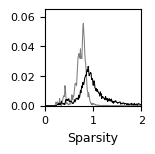

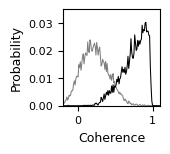

Coherence, Grid vs. Shuff:
Mean, SEM Grid:
0.7827693906051894 0.0023869616308690575
Mean, SEM Shuffle:
0.2922797859137231 0.002396231044659577
stat = 23528.0
p_cells = 0.0

Coherence, NGS vs. Shuff:
Mean, SEM NGS:
0.7419239788222454 0.002050831898278205
Mean, SEM Shuffle:
0.2180273013387769 0.002292555857900311
stat = 329.0
p_cells = 0.0

Coherence, NGS vs. Grid:
Mean, SEM NGS:
0.7419239788222454 0.002050831898278205
Mean, SEM Grid:
0.7827693906051894 0.0023869616308690575
stat = -20.674003911687837
p_cells = 5.9379884436439664e-95

Sparsity, Grid vs. Shuff:
Mean, SEM Grid:
1.2257912236952178 0.009208855518210901
Mean, SEM Shuffle:
0.7402662355715365 0.0018737832882870639
stat = 167734.0
p_cells = 0.0

Sparsity, NGS vs. Shuff:
Mean, SEM NGS:
1.1021215614414288 0.009112407391108976
Mean, SEM Shuffle:
0.724853849639259 0.001798919962001212
stat = 10270.0
p_cells = 0.0

Sparsity, NGS vs. Grid:
Mean, SEM NGS:
1.1021215614414288 0.009112407391108976
Mean, SEM Grid:
1.2257912236952178 0.0092

In [57]:
''' Plot Coherence & Sparsity Score Distributions vs. Shuffle for NGS Cells (Figure S3f) '''
bins = np.arange(0,2,0.01)
bsparsity, bin_edges = np.histogram(ngssparsity, bins = bins)
pdf = bsparsity / sum(bsparsity)

shuffbsparsity, shuffbin_edges = np.histogram(ngsshuffsparsity, bins = bins)
shuffpdf = shuffbsparsity / sum(shuffbsparsity)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
#ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Sparsity', fontsize = 9)
ax.set_xlim([0,2])
ax.set_ylim([0,0.065])
ax.set_yticks([0,0.02,0.04,0.06])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'S3Fright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3Fright.svg', dpi=400, bbox_inches='tight')
plt.show()

bins = np.arange(-0.2,1.1,0.01)
bcoherence, bin_edges = np.histogram(ngscoherence, bins = bins)
pdf = bcoherence / sum(bcoherence)
shuffcoherence, shuffbin_edges = np.histogram(ngsshuffcoherence, bins = bins)
shuffpdf = shuffcoherence / sum(shuffcoherence)

fig, ax = plt.subplots(figsize = (1.25,1.25))
#ax.hist(ngscoherence, 20, density = True, histtype = 'step', color = 'k')
#ax.hist(ngsshuffsparsity, 20, density = True, histtype = 'step', color = 'k', alpha = 0.5)
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Coherence', fontsize = 9)
ax.set_xlim([-0.2,1.1])
ax.set_ylim([0,0.035])
ax.set_yticks([0,0.01,0.02,0.03])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'S3Fleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3Fleft.svg', dpi=400, bbox_inches='tight')
plt.show()

'''
#Optional: check grid cells also!

bins = np.arange(0,2,0.01)
sparsity, bin_edges = np.histogram(gridsparsity, bins = bins)
pdf = sparsity / sum(sparsity)

shuffsparsity, shuffbin_edges = np.histogram(gridshuffsparsity, bins = bins)
shuffpdf = shuffsparsity / sum(shuffsparsity)

fig, ax = plt.subplots(figsize = (1.25,1.25))
#ax.hist(gridsparsity, 20, density = True, histtype = 'step', color = 'k')
#ax.hist(gridshuffsparsity, 20, density = True, histtype = 'step', color = 'k', alpha = 0.5)
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Sparsity', fontsize = 9)
ax.set_xlim([0,2])
ax.set_ylim([0,0.06])
ax.set_yticks([0,0.02,0.04,0.06])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'gridsparsity.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'gridsparsity.svg', dpi=400, bbox_inches='tight')
plt.show()

bins = np.arange(-0.2,1.1,0.01)
coherence, bin_edges = np.histogram(gridcoherence, bins = bins)
pdf = coherence / sum(coherence)

shuffgsparsity, shuffbin_edges = np.histogram(gridshuffcoherence, bins = bins)
shuffpdf = shuffcoherence / sum(shuffcoherence)

fig, ax = plt.subplots(figsize = (1.25,1.25))
#ax.hist(gridcoherence, 20, density = True, histtype = 'step', color = 'k')
#ax.hist(gridshuffsparsity, 20, density = True, histtype = 'step', color = 'k', alpha = 0.5)
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Coherence', fontsize = 9)
ax.set_xlim([-0.2,1.1])
ax.set_ylim([0,0.05])
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'gridcoherence.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'gridcoherence.svg', dpi=400, bbox_inches='tight')
plt.show()
'''

#STATS
print('Coherence, Grid vs. Shuff:')
print('Mean, SEM Grid:')
print(np.nanmean(gridcoherence), stats.sem(gridcoherence, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(gridshuffcoherence), stats.sem(gridshuffcoherence, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(gridcoherence, gridshuffcoherence)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

print('\nCoherence, NGS vs. Shuff:')
print('Mean, SEM NGS:')
print(np.nanmean(ngscoherence), stats.sem(ngscoherence, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(ngsshuffcoherence), stats.sem(ngsshuffcoherence, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(ngscoherence[~np.isnan(ngsshuffcoherence)], ngsshuffcoherence[~np.isnan(ngsshuffcoherence)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

print('\nCoherence, NGS vs. Grid:')
print('Mean, SEM NGS:')
print(np.nanmean(ngscoherence), stats.sem(ngscoherence, nan_policy = 'omit')) 
print('Mean, SEM Grid:')
print(np.nanmean(gridcoherence), stats.sem(gridcoherence, nan_policy = 'omit')) 
stat, p_diff = stats.ranksums(ngscoherence, gridcoherence)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#STATS
print('\nSparsity, Grid vs. Shuff:')
print('Mean, SEM Grid:')
print(np.nanmean(gridsparsity), stats.sem(gridsparsity, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(gridshuffsparsity), stats.sem(gridshuffsparsity, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(gridsparsity, gridshuffsparsity)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

print('\nSparsity, NGS vs. Shuff:')
print('Mean, SEM NGS:')
print(np.nanmean(ngssparsity), stats.sem(ngssparsity, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(ngsshuffsparsity), stats.sem(ngsshuffsparsity, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(ngssparsity[~np.isnan(ngsshuffsparsity)], ngsshuffsparsity[~np.isnan(ngsshuffsparsity)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

print('\nSparsity, NGS vs. Grid:')
print('Mean, SEM NGS:')
print(np.nanmean(ngssparsity), stats.sem(ngssparsity, nan_policy = 'omit')) 
print('Mean, SEM Grid:')
print(np.nanmean(gridsparsity), stats.sem(gridsparsity, nan_policy = 'omit')) 
stat, p_diff = stats.ranksums(ngssparsity, gridsparsity)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

In [58]:
''' Compare Grid vs. NGS Cell Response to Gain Change by Age Group'''
dt = 0.02
b = 2

#age group arrays
crossAgrida = []
crossAgridma = []
crossAgridy = []
crossAngsa = []
crossAngsma = []
crossAngsy = []
crossBgrida = []
crossBgridma = []
crossBgridy = []
crossBngsa = []
crossBngsma = []
crossBngsy = []

for m, session in zip(mice,sessions):
    
    m_crossAgrid = []
    m_crossAngs = []
    m_crossBgrid = []
    m_crossBngs = []

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        
        # maps including equal numbers normal & gain-adjusted trials removing skipped trials
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        gain = trialinfo['gain']
        
        #check if mouse reached gain period; if not append NaN to all arrays & continue 
        if len(gain) < 200:
            #print(str(m) + str(s) + ' did not reach gain change')
            continue 
            
        # get alt A' and B' trials
        A_trials = np.where((left == 1))[0]
        A_trials = list(A_trials[A_trials >= 140])
        B_trials = np.where((left == 0))[0]
        B_trials = list(B_trials[B_trials >= 140])
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
            
        alltrial = np.arange(0,220,1)
            
        #remove any skipped trials from A' and B'    
        for n, t in enumerate(skippedtrials):
            if t in A_trials:
                A_trials.remove(t)
            elif t in B_trials:
                B_trials.remove(t)
    
        #get count of gain in each context & select equal number of last Context A or B alt trials before gain
        gain_trials = np.where((gain == 0.7))[0]
        gain_trials = list(gain_trials)
        nagain = len(np.intersect1d(np.asarray(A_trials), np.asarray(gain_trials)))
        nbgain = len(np.intersect1d(np.asarray(B_trials), np.asarray(gain_trials)))
        
        Agtrials = []
        A_trials = np.asarray(A_trials)
        for n in range(0, nagain):
            Agtrials = np.append(Agtrials, A_trials[A_trials < 200][-(n+1)])
        Agtrials = np.append(Agtrials, np.intersect1d(A_trials, np.asarray(gain_trials)))
        Agtrials = list(np.sort(Agtrials.astype(int)))  
             
        nbgain = len(np.intersect1d(np.asarray(B_trials), np.asarray(gain_trials)))
        Bgtrials = []
        B_trials = np.asarray(B_trials)
        for n in range(0, nbgain):
            Bgtrials = np.append(Bgtrials, B_trials[B_trials < 200][-(n+1)])
        Bgtrials = np.append(Bgtrials, np.intersect1d(B_trials, np.asarray(gain_trials)))                   
        Bgtrials = list(np.sort(Bgtrials.astype(int)))
    
        #get indices of observations corresponding to the selected trials
        Agidx = []
        for t in Agtrials:
            Agidx = np.append(Agidx, np.where(trial == t)[0])
        Agidx = Agidx.astype(int)
            
        Bgidx = []
        for t in Bgtrials:
            Bgidx = np.append(Bgidx, np.where(trial == t)[0])
        Bgidx = Bgidx.astype(int)
        
        #Get A (normal & gain alt) & B (normal & gain alt) spatial maps
        #handle edge cases where there aren't any gain change trials in one map or another
        if len(Bgidx) == 0:
            print(str(m) + str(s) + ' no B gain change trials')
            gainAFR, _, _ = ps.tuning_curve_bytrial(posx[Agidx], trial[Agidx], Y[Agidx,:], dt, sigma = 2, b=2, smooth=True, normalize=False, occupancy=True)
            
            #get difference in avg. pairwise cross_trial_correlation btwn baseline & gain change trials for each context
            deltA = []
            deltB = []
            for i, c in enumerate(cell_IDs):
                sdx = (np.where(cell_IDs == c)[0][0]).astype(int)

                #ContextA
                sim, _  = ps.cross_trial_correlation(gainAFR[:,:,sdx], shift = False) 
                baseline_sim = pd.DataFrame(sim[:nagain,:nagain])
                baseline_avg = ((baseline_sim.sum().sum() - nagain) / 2) / ((nagain**2 - nagain)/2)
                gain_sim = pd.DataFrame(sim[nagain:,:nagain])
                gain_avg = ((gain_sim.sum().sum() - nagain) / 2) / ((nagain**2 - nagain)/2)
                deltA = np.append(deltA, (baseline_avg - gain_avg))

            #pool by age group
            if m in SM_aged_mice:
                crossAgrida = np.append(crossAgrida, deltA[gridcell])
                crossAngsa = np.append(crossAngsa, deltA[ngscell])
                crossBgrida = np.append(crossBgrida, np.nan)
                crossBngsa = np.append(crossBngsa, np.nan)
            elif m in SM_MA_mice:
                crossAgridma = np.append(crossAgridma, deltA[gridcell])
                crossAngsma = np.append(crossAngsma, deltA[ngscell])
                crossBgridma = np.append(crossBgridma, np.nan)
                crossBngsma = np.append(crossBngsma, np.nan)
            else:
                crossAgridy = np.append(crossAgridy, deltA[gridcell])
                crossAngsy = np.append(crossAngsy, deltA[ngscell])
                crossBgridy = np.append(crossBgridy, np.nan)
                crossBngsy = np.append(crossBngsy, np.nan)
        
        elif len(Agidx) == 0:
            print(str(m) + str(s) + ' no A gain change trials')
            gainBFR, _, _ = ps.tuning_curve_bytrial(posx[Bgidx], trial[Bgidx], Y[Bgidx,:], dt, sigma = 2, b=2, smooth=True, normalize=False, occupancy=True)
        
            #get difference in avg. pairwise cross_trial_correlation btwn baseline & gain change trials for each context
            deltA = []
            deltB = []
            for i, c in enumerate(spatialcells):
                sdx = (np.where(cell_IDs == c)[0][0]).astype(int)

                #ContextB
                sim, _ = ps.cross_trial_correlation(gainBFR[:,:,sdx], shift = False) 
                baseline_sim = pd.DataFrame(sim[:nbgain,:nbgain])
                baseline_avg = ((baseline_sim.sum().sum() - nbgain) / 2) / ((nbgain**2 - nbgain)/2)
                gain_sim = pd.DataFrame(sim[nbgain:,:nbgain])
                gain_avg = ((gain_sim.sum().sum() - nbgain) / 2) / ((nbgain**2 - nbgain)/2)
                deltB = np.append(deltB, (baseline_avg - gain_avg))
                
            #pool by age group
            if m in SM_aged_mice:
                crossAgrida = np.append(crossAgrida, np.nan)
                crossAngsa = np.append(crossAngsa, np.nan)
                crossBgrida = np.append(crossBgrida, deltB[gridcell])
                crossBngsa = np.append(crossBngsa, deltB[ngscell])
            elif m in SM_MA_mice:
                crossAgridma = np.append(crossAgridma, np.nan)
                crossAngsma = np.append(crossAngsma, np.nan)
                crossBgridma = np.append(crossBgridma, deltB[gridcell])
                crossBngsma = np.append(crossBngsma, deltB[ngscell])
            else:
                crossAgridy = np.append(crossAgridy, np.nan)
                crossAngsy = np.append(crossAngsy, np.nan)
                crossBgridy = np.append(crossBgridy, deltB[gridcell])
                crossBngsy = np.append(crossBngsy, deltB[ngscell])
                
        else:
            gainAFR, _, _ = ps.tuning_curve_bytrial(posx[Agidx], trial[Agidx], Y[Agidx,:], dt, sigma = 2, b=2, smooth=True, normalize=False, occupancy=True)
            gainBFR, _, _ = ps.tuning_curve_bytrial(posx[Bgidx], trial[Bgidx], Y[Bgidx,:], dt, sigma = 2, b=2, smooth=True, normalize=False, occupancy=True)
             
            #get difference in avg. pairwise cross_trial_correlation btwn baseline & gain change trials for each context
            deltA = []
            deltB = []
            for i, c in enumerate(cell_IDs):
                sdx = (np.where(cell_IDs == c)[0][0]).astype(int)

                #ContextA
                sim, _  = ps.cross_trial_correlation(gainAFR[:,:,sdx], shift = False) 
                baseline_sim = pd.DataFrame(sim[:nagain,:nagain]) #non-gain vs. non-gain
                baseline_avg = ((baseline_sim.sum().sum() - nagain) / 2) / ((nagain**2 - nagain)/2)
                gain_sim = pd.DataFrame(sim[nagain:,:nagain]) #gain vs. non-gain
                gain_avg = ((gain_sim.sum().sum() - nagain) / 2) / ((nagain**2 - nagain)/2)
                deltA = np.append(deltA, (baseline_avg - gain_avg))

                #ContextB
                sim, _ = ps.cross_trial_correlation(gainBFR[:,:,sdx], shift = False) 
                baseline_sim = pd.DataFrame(sim[:nbgain,:nbgain])
                baseline_avg = ((baseline_sim.sum().sum() - nbgain) / 2) / ((nbgain**2 - nbgain)/2)
                gain_sim = pd.DataFrame(sim[nbgain:,:nbgain])
                gain_avg = ((gain_sim.sum().sum() - nbgain) / 2) / ((nbgain**2 - nbgain)/2)
                deltB = np.append(deltB, (baseline_avg - gain_avg))

            #pool by age group
            if m in SM_aged_mice:
                crossAgrida = np.append(crossAgrida, deltA[gridcell])
                crossAngsa = np.append(crossAngsa, deltA[ngscell])
                crossBgrida = np.append(crossBgrida, deltB[gridcell])
                crossBngsa = np.append(crossBngsa, deltB[ngscell])
            elif m in SM_MA_mice:
                crossAgridma = np.append(crossAgridma, deltA[gridcell])
                crossAngsma = np.append(crossAngsma, deltA[ngscell])
                crossBgridma = np.append(crossBgridma, deltB[gridcell])
                crossBngsma = np.append(crossBngsma, deltB[ngscell])
            else:
                crossAgridy = np.append(crossAgridy, deltA[gridcell])
                crossAngsy = np.append(crossAngsy, deltA[ngscell])
                crossBgridy = np.append(crossBgridy, deltB[gridcell])
                crossBngsy = np.append(crossBngsy, deltB[ngscell])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Y22092922_record5 no B gain change trials


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

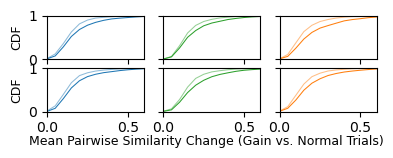

In [59]:
''' Plot Gain Change Response CDF by Age Group (Figure S3h)'''

bins = np.arange(-0.2,0.8,0.05)
fig, ax = plt.subplots(2,3, figsize = (4.25, 1.25), sharey = True, sharex = True)
#fig.suptitle('Avg. Pairwise Cross Correlation Change', fontsize = 10)

# Young A Grid vs. ngs
y, bin_edges = np.histogram(crossAgridy, bins = bins)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax[0,0].plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', label = 'grid')

y, bin_edges = np.histogram(crossAngsy, bins = bins)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax[0,0].plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', alpha = 0.5, label = 'ngs')
ax[0,0].set_ylabel('CDF', fontsize = 9)
#ax[0,0].legend(fontsize = 9)

# MA A Grid vs. ngs
ma, bin_edges = np.histogram(crossAgridma, bins = bins)
pdf = ma / sum(ma)
macdf = np.cumsum(pdf)
ax[0,1].plot(bin_edges[1:], macdf, '-', linewidth = 0.75, color = 'C2', label = 'grid')

ma, bin_edges = np.histogram(crossAngsma, bins = bins)
pdf = ma / sum(ma)
macdf = np.cumsum(pdf)
ax[0,1].plot(bin_edges[1:], macdf, '-', linewidth = 0.75, color = 'C2', label = 'ngs', alpha = 0.5)

# Aged A Grid vs. ngs
a, bin_edges = np.histogram(crossAgrida, bins = bins)
pdf = a / sum(a)
acdf = np.cumsum(pdf)
ax[0,2].plot(bin_edges[1:], acdf, '-', linewidth = 0.75, color = 'C1', label = 'grid')

a, bin_edges = np.histogram(crossAngsa, bins = bins)
pdf = a / sum(a)
acdf = np.cumsum(pdf)
ax[0,2].plot(bin_edges[1:], acdf, '-', linewidth = 0.75, color = 'C1', label = 'ngs', alpha = 0.5)

# Young B Grid vs. ngs
y, bin_edges = np.histogram(crossBgridy, bins = bins)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax[1,0].plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', label = 'grid')

y, bin_edges = np.histogram(crossBngsy, bins = bins)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax[1,0].plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', alpha = 0.5, label = 'ngs')
ax[1,0].set_ylabel('CDF', fontsize = 9)
#ax[1,0].legend(fontsize = 9)

# MA B Grid vs. ngs
ma, bin_edges = np.histogram(crossBgridma, bins = bins)
pdf = ma / sum(ma)
macdf = np.cumsum(pdf)
ax[1,1].plot(bin_edges[1:], macdf, '-', linewidth = 0.75, color = 'C2', label = 'grid')

ma, bin_edges = np.histogram(crossBngsma, bins = bins)
pdf = ma / sum(ma)
macdf = np.cumsum(pdf)
ax[1,1].plot(bin_edges[1:], macdf, '-', linewidth = 0.75, color = 'C2', label = 'ngs', alpha = 0.5)
#ax[1,0].legend(fontsize = 9)

# Aged B Grid vs. ngs
a, bin_edges = np.histogram(crossBgrida, bins = bins)
pdf = a / sum(a)
acdf = np.cumsum(pdf)
ax[1,2].plot(bin_edges[1:], acdf, '-', linewidth = 0.75, color = 'C1', label = 'grid')

a, bin_edges = np.histogram(crossBngsa, bins = bins)
pdf = a / sum(a)
acdf = np.cumsum(pdf)
ax[1,2].plot(bin_edges[1:], acdf, '-', linewidth = 0.75, color = 'C1', label = 'ngs', alpha = 0.5)

fig.supxlabel('Mean Pairwise Similarity Change (Gain vs. Normal Trials)', fontsize = 9, y = -0.18)
ax[0,0].set_xlim([0,0.6])
ax[0,0].set_ylim([0,1])

plt.savefig(save_folder + 'S3H.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3H.svg', dpi=400, bbox_inches='tight')
plt.show()

In [60]:
'''Wilcoxon Rank Sums Comparison of Grid vs. NGS Cell Gain Change Response (by Age Group x Context)'''
print('\nYoung A Grid vs. ngs:')
print('crossAyoung_grid ± SEM, crossAyoung_ngs ± SEM')
print(str(np.round(np.nanmean(crossAgridy[~np.isnan(crossAgridy)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAgridy[~np.isnan(crossAgridy)]), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossAngsy[~np.isnan(crossAngsy)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAngsy[~np.isnan(crossAngsy)]), 3)))

stat, p_diff = stats.ranksums(crossAgridy[~np.isnan(crossAgridy)],crossAngsy[~np.isnan(crossAngsy)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

print('\nYoung B Grid vs. ngs:')
print('crossByoung_grid ± SEM, crossByoung_ngs ± SEM')
print(str(np.round(np.nanmean(crossBgridy[~np.isnan(crossBgridy)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBgridy[~np.isnan(crossBgridy)], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossBngsy[~np.isnan(crossBngsy)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBngsy[~np.isnan(crossBngsy)], nan_policy = 'omit'), 3)))

stat, p_diff = stats.ranksums(crossBgridy[~np.isnan(crossBgridy)],crossBngsy[~np.isnan(crossBngsy)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

print('\nMA A Grid vs. ngs:')
print('crossAMA_grid ± SEM, crossAMA_ngs ± SEM')
print(str(np.round(np.nanmean(crossAgridma[~np.isnan(crossAgridma)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAgridma[~np.isnan(crossAgridma)]), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossAngsma[~np.isnan(crossAngsma)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAngsma[~np.isnan(crossAngsma)]), 3)))

stat, p_diff = stats.ranksums(crossAgridma[~np.isnan(crossAgridma)],crossAngsma[~np.isnan(crossAngsma)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

print('\nMA B Grid vs. ngs:')
print('crossBMA_grid ± SEM, crossBMA_ngs ± SEM')
print(str(np.round(np.nanmean(crossBgridma[~np.isnan(crossBgridma)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBgridma[~np.isnan(crossBgridma)], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossBngsma[~np.isnan(crossBngsma)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBngsma[~np.isnan(crossBngsma)], nan_policy = 'omit'), 3)))

stat, p_diff = stats.ranksums(crossBgridma[~np.isnan(crossBgridma)],crossBngsma[~np.isnan(crossBngsma)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

print('\nAged A Grid vs. ngs:')
print('crossAAged_grid ± SEM, crossAAged_ngs ± SEM')
print(str(np.round(np.nanmean(crossAgrida[~np.isnan(crossAgrida)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAgrida[~np.isnan(crossAgrida)]), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossAngsa[~np.isnan(crossAngsa)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAngsa[~np.isnan(crossAngsa)]), 3)))

stat, p_diff = stats.ranksums(crossAgrida[~np.isnan(crossAgrida)],crossAngsa[~np.isnan(crossAngsa)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

print('\nAged B Grid vs. ngs:')
print('crossBAged_grid ± SEM, crossBAged_ngs ± SEM')
print(str(np.round(np.nanmean(crossBgrida[~np.isnan(crossBgrida)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBgrida[~np.isnan(crossBgrida)], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossBngsa[~np.isnan(crossBngsa)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBngsa[~np.isnan(crossBngsa)], nan_policy = 'omit'), 3)))

stat, p_diff = stats.ranksums(crossBgrida[~np.isnan(crossBgrida)],crossBngsa[~np.isnan(crossBngsa)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))



Young A Grid vs. ngs:
crossAyoung_grid ± SEM, crossAyoung_ngs ± SEM
0.194 ± 0.003 ; 0.144 ± 0.002
stat = 10.32908575823185
p_session, P = 5.205433843513019e-25

Young B Grid vs. ngs:
crossByoung_grid ± SEM, crossByoung_ngs ± SEM
0.188 ± 0.003 ; 0.141 ± 0.002
stat = 10.426019150111031
p_session, P = 1.8862615860032924e-25

MA A Grid vs. ngs:
crossAMA_grid ± SEM, crossAMA_ngs ± SEM
0.195 ± 0.003 ; 0.159 ± 0.002
stat = 7.721288771775169
p_session, P = 1.1515931953677169e-14

MA B Grid vs. ngs:
crossBMA_grid ± SEM, crossBMA_ngs ± SEM
0.209 ± 0.003 ; 0.163 ± 0.002
stat = 10.5627507171043
p_session, P = 4.4347250232300257e-26

Aged A Grid vs. ngs:
crossAAged_grid ± SEM, crossAAged_ngs ± SEM
0.217 ± 0.004 ; 0.15 ± 0.002
stat = 13.089653036302872
p_session, P = 3.773274969511856e-39

Aged B Grid vs. ngs:
crossBAged_grid ± SEM, crossBAged_ngs ± SEM
0.198 ± 0.003 ; 0.143 ± 0.002
stat = 11.594402511167353
p_session, P = 4.399249704484284e-31


# Grid Cell Stability, Context-Matched Similarity, & Similarity Ratio

Figures 2f - i. You can skip to this session after setting up and loading in grid cell booleans. 

In [23]:
''' Compute & Plot Sorted Cross-Trial Correlation Matrices for Grid Cells; Save Matrices for Later Use 

Run time is a few minutes per session (scales w/ grid cell number).

'''
for m, session in zip(mice,sessions):

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)
        
        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(gridcells)))
        for i, c in enumerate(gridcells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim
            
        # save matrix of cross-trial correlations
        d['allgridsim'] = allsim
                               
        #allgridsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
        #np.save(save_folder + allgridsim_file, allsim)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [24]:
''' Calculate Local Cross Trial Correlation Stability within Each Context'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

slocstab5A = []
slocstab5B = []
slocstab5A_ = []
slocstab5B_ = []
slocstab5block = []
slocstab5alt = []

mlocstab5A = []
mlocstab5B = []
mlocstab5A_ = []
mlocstab5B_ = []
max_k = 5

#cell arrays
ylocstab5A = []
ylocstab5B = []
ylocstab5A_ = []
ylocstab5B_ = []
ylocstab5block = []
ylocstab5alt = []

malocstab5A = []
malocstab5B = []
malocstab5A_ = []
malocstab5B_ = []
malocstab5block = []
malocstab5alt = []

alocstab5A = []
alocstab5B = []
alocstab5A_ = []
alocstab5B_ = []
alocstab5block = []
alocstab5alt = []

blockstability = []

for m, session in zip(mice, sessions):
    
    m_locstab5A = []
    m_locstab5B = []
    m_locstab5A_ = []
    m_locstab5B_ = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]   
        
        trial = behaviorfil[:,2]
        
        #load the context lengths, exclude A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx']
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        #allgridsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
        #d['allgridsim'] = np.load(save_folder + allgridsim_file)
        allgridsim = d['allgridsim']
        
        local_stabilityA = []
        local_stabilityB = []
        local_stabilityA_ = []
        local_stabilityB_ = []
        local_stabilityblock = [] 
        local_stabilityalt = []
        for i, c in enumerate(gridcells):
            
            #divide sim by context
            sim = allgridsim[:,:,i]
            simA = sim[:lengthA,:lengthA]
            simB = sim[lengthA:(lengthA + lengthB),lengthA:(lengthA + lengthB)]
            simblock = sim[:(lengthA + lengthB),:(lengthA + lengthB)]
            simalt = sim[(lengthA + lengthB):,(lengthA + lengthB):]
            simA_ = sim[(lengthA + lengthB):(lengthA + lengthB + lengthA_), (lengthA + lengthB):(lengthA + lengthB + lengthA_)]
            simB_ = sim[(lengthA + lengthB + lengtha_):(lengthA + lengthB + lengtha_ + lengthB_),(lengthA + lengthB + lengtha_):(lengthA + lengthB + lengtha_ + lengthB_)]
            
            # Context A local neighborhood 5 trials
            max_k = 5
            sum_k = np.zeros(simA.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simA, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simA, offset=k)
            local_stabilityA = np.append(local_stabilityA, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 1

            #Context B
            max_k = 5
            sum_k = np.zeros(simB.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simB, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simB, offset=k)
            local_stabilityB = np.append(local_stabilityB, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 2

            #Context A_
            max_k = 5
            sum_k = np.zeros(simA_.shape[0])
            
            if simA_.shape[0] <= 2*max_k:
                print(m, s, simA_.shape[0], simB_.shape[0])
                max_k = simA_.shape[0]//2
                max_k = 3
                
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simA_, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simA_, offset=k)
                    
            local_stabilityA_ = np.append(local_stabilityA_, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 3
            
            #Context B_
            if simB_.shape[0] <= 10:
                print('keeping lower max k for B_...' + str(max_k))
            else: 
                max_k = 5
                
            sum_k = np.zeros(simB_.shape[0])
            
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simB_, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simB_, offset=k)
                    
            local_stabilityB_ = np.append(local_stabilityB_, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 3
            
            #Block Stability
            max_k = 5  
            sum_k = np.zeros(simblock.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simblock, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simblock, offset=k)
            local_stabilityblock = np.append(local_stabilityblock, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
            #Alt Stability
            max_k = 5  
            sum_k = np.zeros(simalt.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simalt, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simalt, offset=k)
            local_stabilityalt = np.append(local_stabilityalt, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
        #save session results
        slocstab5A = np.append(slocstab5A, np.nanmean(local_stabilityA))
        m_locstab5A = np.append(m_locstab5A, local_stabilityA)
        slocstab5B = np.append(slocstab5B, np.nanmean(local_stabilityB))
        m_locstab5B = np.append(m_locstab5B, local_stabilityB)
        slocstab5A_ = np.append(slocstab5A_, np.nanmean(local_stabilityA_))
        m_locstab5A_ = np.append(m_locstab5A_, local_stabilityA_)    
        slocstab5B_ = np.append(slocstab5B_, np.nanmean(local_stabilityB_))
        m_locstab5B_ = np.append(m_locstab5B_, local_stabilityB_)
        
        slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
        slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))
        
        #pool by age group
        if m in SM_aged_mice:
            alocstab5A = np.append(alocstab5A, local_stabilityA) 
            alocstab5B = np.append(alocstab5B, local_stabilityB) 
            alocstab5A_ = np.append(alocstab5A_, local_stabilityA_) 
            alocstab5B_ = np.append(alocstab5B_, local_stabilityB_) 
            alocstab5block = np.append(alocstab5block, local_stabilityblock) 
            alocstab5alt = np.append(alocstab5alt, local_stabilityalt) 
        elif m in SM_MA_mice:
            malocstab5A = np.append(malocstab5A, local_stabilityA) 
            malocstab5B = np.append(malocstab5B, local_stabilityB) 
            malocstab5A_ = np.append(malocstab5A_, local_stabilityA_) 
            malocstab5B_ = np.append(malocstab5B_, local_stabilityB_) 
            malocstab5block = np.append(malocstab5block, local_stabilityblock) 
            malocstab5alt = np.append(malocstab5alt, local_stabilityalt) 
        else:
            ylocstab5A = np.append(ylocstab5A, local_stabilityA) 
            ylocstab5B = np.append(ylocstab5B, local_stabilityB) 
            ylocstab5A_ = np.append(ylocstab5A_, local_stabilityA_) 
            ylocstab5B_ = np.append(ylocstab5B_, local_stabilityB_) 
            ylocstab5block = np.append(ylocstab5block, local_stabilityblock) 
            ylocstab5alt = np.append(ylocstab5alt, local_stabilityalt) 
            
    #pool by animal
    mlocstab5A = np.append(mlocstab5A, np.nanmean(m_locstab5A))
    mlocstab5B = np.append(mlocstab5B, np.nanmean(m_locstab5B))
    mlocstab5A_ = np.append(mlocstab5A_, np.nanmean(m_locstab5A_))
    mlocstab5B_ = np.append(mlocstab5B_, np.nanmean(m_locstab5B_))

#save arrays
slocstab5A = np.asarray(slocstab5A)
slocstab5B = np.asarray(slocstab5B)
slocstab5A_ = np.asarray(slocstab5A_)
slocstab5B_ = np.asarray(slocstab5B_)
slocstab5block = np.asarray(slocstab5block)
slocstab5alt = np.asarray(slocstab5alt)

mlocstab5A = np.asarray(mlocstab5A)
mlocstab5B = np.asarray(mlocstab5B)
mlocstab5A_ = np.asarray(mlocstab5A_)
mlocstab5B_ = np.asarray(mlocstab5B_)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_13884\94602929.py:189: RuntimeWarning: Mean of empty slice
  slocstab5A = np.append(slocstab5A, np.nanmean(local_stabilityA))
C:\Users\Python\AppData\Local\Temp\ipykernel_13884\94602929.py:191: RuntimeWarning: Mean of empty slice
  slocstab5B = np.append(slocstab5B, np.nanmean(local_stabilityB))
C:\Users\Python\AppData\Local\Temp\ipykernel_13884\94602929.py:193: RuntimeWarning: Mean of empty slice
  slocstab5A_ = np.append(slocstab5A_, np.nanmean(local_stabilityA_))
C:\Users\Python\AppData\Local\Temp\ipykernel_13884\94602929.py:195: RuntimeWarning: Mean of empty slice
  slocstab5B_ = np.append(slocstab5B_, np.nanmean(local_stabilityB_))
C:\Users\Python\AppData\Local\Temp\ipykernel_13884\94602929.py:198: RuntimeWarning: Mean of empty slice
  slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
C:\Users\Python\AppData\Local\Temp\ipykernel_13884\94602929.py:199: RuntimeWarning: Mean of empty slice
  slocstab5alt = np.app

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Grid Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []
cengageA = []
cengageB = []
cengageA_ = []
cengageB_ = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        try:
            engagement_file = 'engagement_' + str(m) + '_' + str(s) + '.npy'
            blocknclickrate = np.load(engagement_folder + engagement_file)
        
        except: #if a session's behavioral data is not used for Figure 1/S1/S2, generate engagement data. 
            speed = raw.item().get('speed')
            posx = raw.item().get('posx')
            post = raw.item().get('post')
            lick_ct = d['reward_data']['lick_ct']
            trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
            reward = raw.item().get('reward')
            reward['trials'] = np.arange(0,len(reward['trials']),1)
            dt = np.unique(np.round(np.diff(post),4))
            if len(dt) > 1:
                dt = dt[dt != 0]

            # remove reward data pertaining to dark trials & skipped trials
            try:
                _ = raw.item().get('correctedtrial').shape
                skippedtrials = get.find_skipped(trial, max_trial_num = 220)
                nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
                k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
                keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)

            except:
                skippedtrials = []
                trial = raw.item().get('trial')
                keep_idx = (np.where(reward['trials'] > trials_dark))
                centers = np.array(reward['centers'][keep_idx])
                trials = np.array(reward['trials'][keep_idx])
                misses = reward['missed'][keep_idx].astype(bool)
                requests = ~misses 

            # get indices for reward zone (center ±25cm) & opp reward zone
            start_idx = []
            end_idx = [] 

            for t, c in zip(trials, centers):
                trial_pos = posx.copy()
                start_trial_ind = np.where(trial == t)[0][0]
                t_posx = trial_pos[trial == t]

                zone_start = c - 25 
                zone_end = c + 25

                if c == 270: 
                    oppzone_start = 370 - 25
                    oppzone_end = 370 + 25
                else: 
                    oppzone_start = 270 - 25
                    oppzone_end = 270 + 25

                s_idx = np.argmin(np.abs(t_posx - zone_start)) 
                st_idx = s_idx + start_trial_ind
                e_idx = np.argmin(np.abs(t_posx[s_idx:] - zone_end)) + st_idx

                start_idx.append(st_idx)
                end_idx.append(e_idx)

            start_idx = np.asarray(start_idx)
            end_idx = np.asarray(end_idx)

            # Remove any consummatory licks 
            nclick_ct = lick_ct.copy()
            for k in range(start_idx.shape[0]):
                st = start_idx[k]
                e = end_idx[k] + 1
                nclick_ct[st:e] = False

            # Get total nclicks/trial, save block & alternation mean for sessions, collect all values for animals
            nclickpertrial = []
            for t in trials:
                nclickpertrial = np.append(nclickpertrial, np.sum(nclick_ct[trial == t]))

            # Set up mean engagement array by context (A, B, A', B')
            blocknclickrate = []
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[trials < 81])) 
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[(trials >= 81) & (trials < 141)]))
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[(trials >= 141) & (centers == centers[0])]))
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[(trials >= 141) & (centers == centers[60])]))
            
        for j, c in enumerate(gridcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            cengageA = np.append(cengageA, blocknclickrate[0])
            cengageB = np.append(cengageA, blocknclickrate[1])
            cengageA_ = np.append(cengageA, blocknclickrate[2])
            cengageB_ = np.append(cengageA, blocknclickrate[3])
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)
EngageA = list(cengageA)
EngageB = list(cengageB)
EngageA_ = list(cengageA_)
EngageB_ = list(cengageB_)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     locstab5A
No. Observations:     8022        Method:                 REML     
No. Groups:           29          Scale:                  0.0185   
Min. group size:      88          Log-Likelihood:         1084.3626
Max. group size:      506         Converged:              Yes      
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.400    0.037 10.761 0.000  0.327  0.473
C(AgeGroup)[T.2.0]       -0.126    0.055 -2.288 0.022 -0.234 -0.018
C(AgeGroup)[T.3.0]        0.019    0.044  0.425 0.671 -0.067  0.105
C(Sex)[T.M]               0.031    0.058  0.535 0.592 -0.082  0.144
C(Cohort)[T.D]           -0.029    0.071 -0.407 0.684 -0.169  0

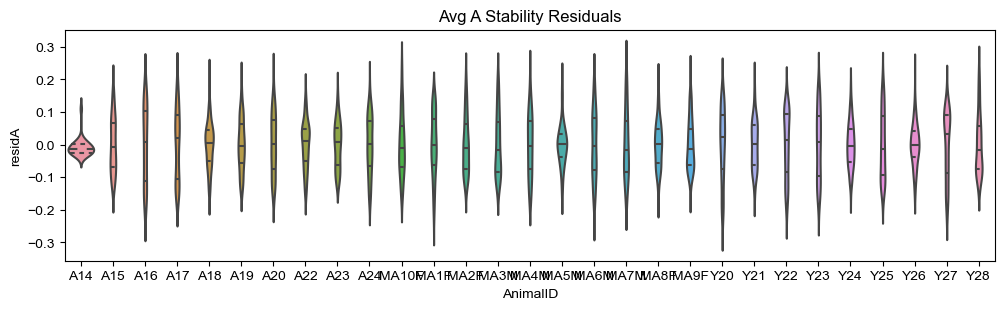

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     locstab5B
No. Observations:     8022        Method:                 REML     
No. Groups:           29          Scale:                  0.0177   
Min. group size:      88          Log-Likelihood:         1404.0666
Max. group size:      506         Converged:              Yes      
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.327    0.040  8.228 0.000  0.249  0.405
C(AgeGroup)[T.2.0]       -0.057    0.059 -0.956 0.339 -0.173  0.060
C(AgeGroup)[T.3.0]        0.003    0.047  0.073 0.942 -0.089  0.095
C(Sex)[T.M]               0.021    0.062  0.342 0.732 -0.101  0.143
C(Cohort)[T.D]            0.014    0.077  0.178 0.859 -0.137  0

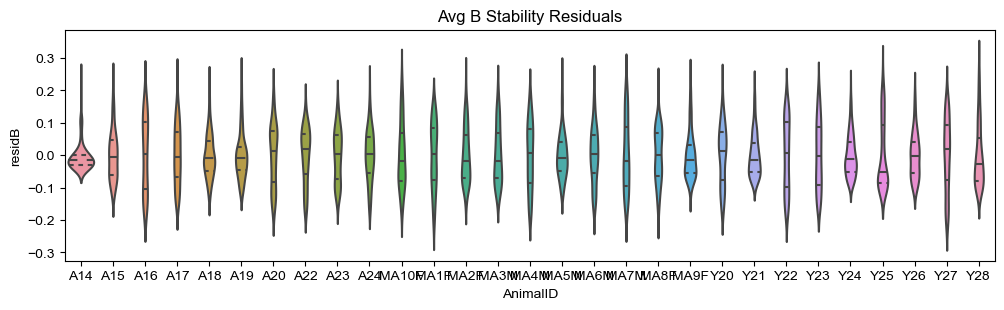

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    locstab5A_
No. Observations:      8022       Method:                REML      
No. Groups:            29         Scale:                 0.0103    
Min. group size:       88         Log-Likelihood:        3604.1072 
Max. group size:       506        Converged:             Yes       
Mean group size:       276.6                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.147    0.031  4.687 0.000  0.086  0.209
C(AgeGroup)[T.2.0]       -0.076    0.047 -1.627 0.104 -0.168  0.016
C(AgeGroup)[T.3.0]        0.080    0.037  2.174 0.030  0.008  0.153
C(Sex)[T.M]               0.042    0.049  0.861 0.389 -0.054  0.139
C(Cohort)[T.D]           -0.036    0.061 -0.589 0.556 -0.155  0

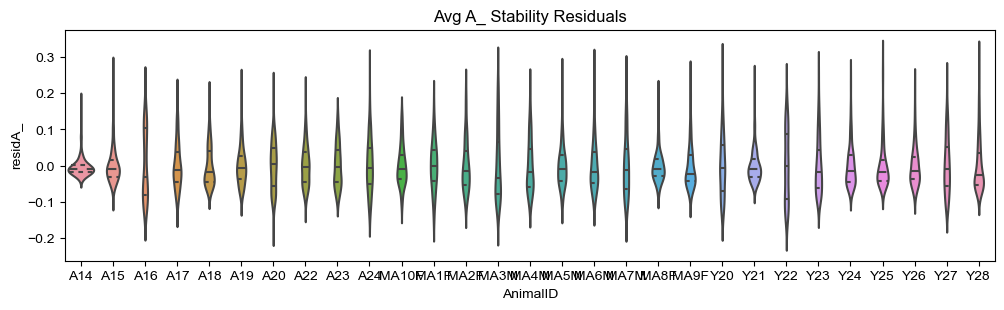

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    locstab5B_
No. Observations:      8022       Method:                REML      
No. Groups:            29         Scale:                 0.0101    
Min. group size:       88         Log-Likelihood:        3661.4222 
Max. group size:       506        Converged:             Yes       
Mean group size:       276.6                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.120    0.030  3.973 0.000  0.061  0.179
C(AgeGroup)[T.2.0]       -0.050    0.045 -1.118 0.264 -0.138  0.038
C(AgeGroup)[T.3.0]        0.072    0.036  2.040 0.041  0.003  0.142
C(Sex)[T.M]               0.046    0.047  0.984 0.325 -0.046  0.139
C(Cohort)[T.D]           -0.019    0.058 -0.334 0.738 -0.134  0

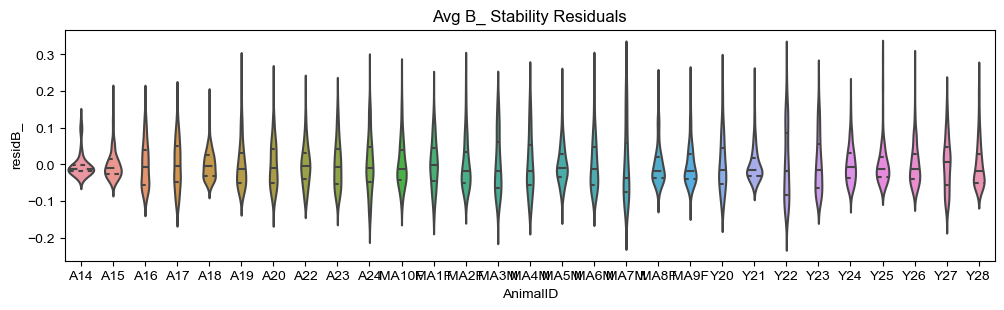

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   locstab5block
No. Observations:     8022      Method:               REML         
No. Groups:           29        Scale:                0.0143       
Min. group size:      88        Log-Likelihood:       2282.5418    
Max. group size:      506       Converged:            Yes          
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.323    0.036  8.982 0.000  0.253  0.394
C(AgeGroup)[T.2.0]       -0.098    0.055 -1.790 0.073 -0.204  0.009
C(AgeGroup)[T.3.0]        0.007    0.043  0.160 0.873 -0.078  0.091
C(Sex)[T.M]               0.030    0.057  0.524 0.601 -0.082  0.142
C(Cohort)[T.D]           -0.020    0.071 -0.276 0.783 -0.158  0

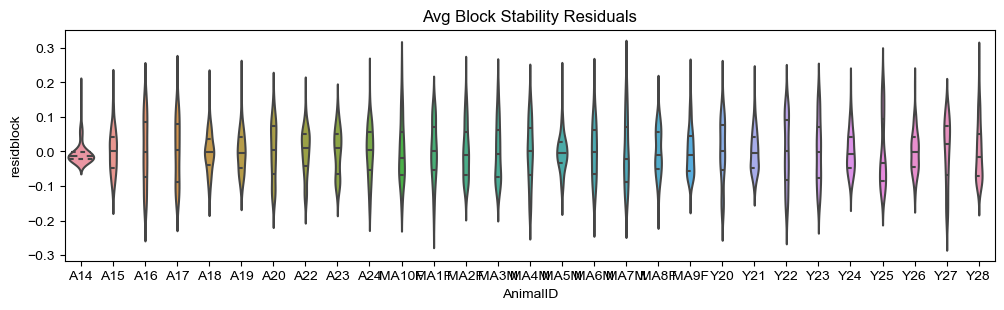

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    locstab5alt
No. Observations:     8022       Method:                REML       
No. Groups:           29         Scale:                 0.0065     
Min. group size:      88         Log-Likelihood:        5453.4517  
Max. group size:      506        Converged:             Yes        
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.133    0.025  5.359 0.000  0.085  0.182
C(AgeGroup)[T.2.0]       -0.061    0.038 -1.616 0.106 -0.135  0.013
C(AgeGroup)[T.3.0]        0.046    0.030  1.539 0.124 -0.013  0.104
C(Sex)[T.M]               0.035    0.040  0.896 0.370 -0.042  0.113
C(Cohort)[T.D]           -0.024    0.049 -0.496 0.620 -0.120  0

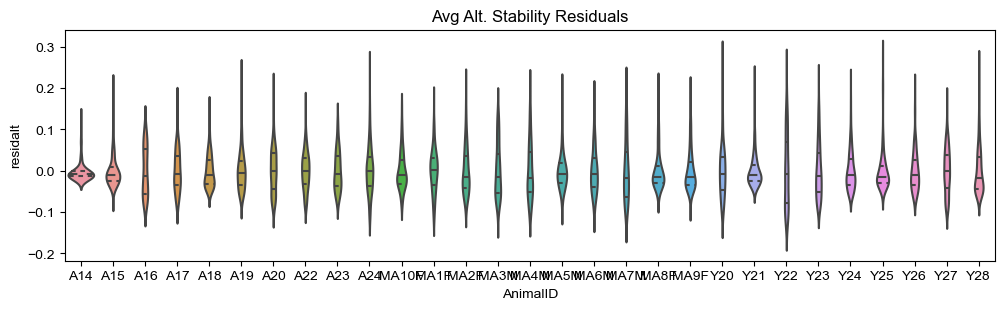

In [26]:
''' LMMs for Moving Avg Similarity [Stability] '''        
#gather dependent variables into lists
locstab5A = list(np.concatenate((alocstab5A, malocstab5A, ylocstab5A)))
locstab5B = list(np.concatenate((alocstab5B, malocstab5B, ylocstab5B)))
locstab5A_ = list(np.concatenate((alocstab5A_, malocstab5A_, ylocstab5A_)))
locstab5B_ = list(np.concatenate((alocstab5B_, malocstab5B_, ylocstab5B_)))
locstab5block = list(np.concatenate((alocstab5block, malocstab5block, ylocstab5block)))
locstab5alt = list(np.concatenate((alocstab5alt, malocstab5alt, ylocstab5alt)))
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, locstab5A, locstab5B, locstab5A_, locstab5B_,locstab5block,locstab5alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','locstab5A','locstab5B', 'locstab5A_', 'locstab5B_','locstab5block','locstab5alt'])

#handle NaNs
df = df.dropna(axis = 0)

#A Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA = smf.mixedlm('locstab5A ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA.summary())
print(mA.wald_test_terms(scalar = False))

df['residA'] = mA.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA', inner = 'quartile', ax = ax)
plt.title('Avg A Stability Residuals')
plt.show()

#B Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB = smf.mixedlm('locstab5B ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB.summary())
print(mB.wald_test_terms(scalar = False))

df['residB'] = mB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB', inner = 'quartile', ax = ax)
plt.title('Avg B Stability Residuals')
plt.show()

#A_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_ = smf.mixedlm('locstab5A_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_.summary())
print(mA_.wald_test_terms(scalar = False))

df['residA_'] = mA_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA_', inner = 'quartile', ax = ax)
plt.title('Avg A_ Stability Residuals')
plt.show()

#B_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB_ = smf.mixedlm('locstab5B_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB_.summary())
print(mB_.wald_test_terms(scalar = False))

df['residB_'] = mB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB_', inner = 'quartile', ax = ax)
plt.title('Avg B_ Stability Residuals')
plt.show()

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Stability Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. Stability Residuals')
plt.show()


In [28]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 8

n aged, MA, young mice on day 1 for B
10 10 8

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
9 10 9

n aged, MA, young mice on day 3 for B
9 10 9

n aged, MA, young mice on day 4 for A
9 9 9

n aged, MA, young mice on day 4 for B
9 9 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
7 9 9

n aged, MA, young mice on day 6 for B
7 9 9


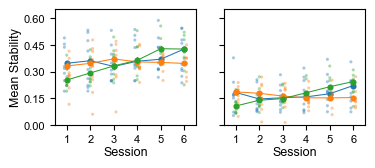

In [31]:
''' Composite Plot of Alternation Stability w/ Fitted Session Average Data Points (Figure 2f)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.15,0.3,0.45,0.6])
ax[0].set_ylim([0.0,0.65])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
#ax[1].set_yticks([0,0.15,0.3,0.45,0.6])
#ax[1].set_ylim([0.0,0.6])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure7A.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure7A.svg', dpi=400, bbox_inches='tight')
plt.show()

In [32]:
''' Find where I will have NaNs'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

# This will fix session stats & box plots are plotted.

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55



Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.14387859322714006 0.5985140360179835 0.6572235404188784 0.4804738597073246
P [Young, MA, Aged, All]: 
0.3040273647840327 8.772079581832069e-07 9.018026689722628e-08 8.538278223852442e-11

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.10474645859479231 0.6510457169229585 0.41722893765772007 0.4061348694153226
P [Young, MA, Aged, All]: 
0.4554022004180901 4.176982503608907e-08 0.0018827315427049083 7.492723972364067e-08

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3790221843695428 0.6554845040859137 0.7207385753532131 0.581314907870872
P [Young, MA, Aged, All]: 
6.160987281288727e-05 2.502513114625307e-15 3.0243577617731763e-18 7.346805492414767e-31

n session halves: young, ma, aged
106 114 106


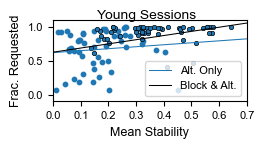

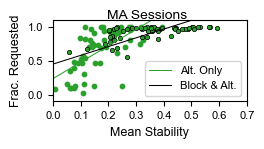

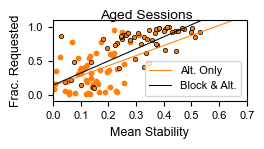

In [36]:
''' Plot Figure 2H with Block & Alt. Data '''
allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindgrid],slocstab5alt[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindgrid],slocstab5alt[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindgrid],slocstab5alt[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure7C_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7C_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure7C_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7C_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure7C_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7C_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [37]:
''' Check Spearmann Correlations'''

allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.spearmanr(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid])
yr1 = res.statistic; yp1 = res.pvalue

res = stats.spearmanr(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid])
mar1 = res.statistic ; map1 = res.pvalue

res = stats.spearmanr(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid])
ar1 = res.statistic ; ap1 = res.pvalue

res = stats.spearmanr(slocstab5block[allidx],reqblock_rates[allidx])
allr1 = res.statistic; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.spearmanr(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid])
yr2 = res.statistic; yp2 = res.pvalue

res = stats.spearmanr(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid])
mar2 = res.statistic ; map2 = res.pvalue

res = stats.spearmanr(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid])
ar2 = res.statistic ; ap2 = res.pvalue

res = stats.spearmanr(slocstab5alt[allidx],reqalt_rates[allidx])
allr2 = res.statistic; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.spearmanr(np.hstack((slocstab5block[y_sindgrid],slocstab5alt[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yr3 = res.statistic; yp3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[ma_sindgrid],slocstab5alt[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
mar3 = res.statistic ; map3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[age_sindgrid],slocstab5alt[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
ar3 = res.statistic ; ap3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allr3 = res.statistic; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3020204095053716 0.5960593044847059 0.6629828282047509 0.4907368530353868
P [Young, MA, Aged, All]: 
0.027954817113998078 9.981108422021092e-07 6.344306292634721e-08 2.9282130774459574e-11

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.18965032318741862 0.6803914645319213 0.34616707705746086 0.43751127598148964
P [Young, MA, Aged, All]: 
0.17378782721344335 5.8126659311930494e-09 0.011114489989267536 5.225403071514056e-09

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5008056199132643 0.7141309204118356 0.7397240313244159 0.6433478773801296
P [Young, MA, Aged, All]: 
4.5720871466994256e-08 4.686209398620998e-19 1.3413196255378623e-19 1.769538748177944e-39


In [38]:
''' Find Context Match / Mismatch Similarity Ratio '''

sABratio = []
sA_B_ratio = []
sAB_ratio = []

yABratio = []
yA_B_ratio = []
yAB_ratio = []
maABratio = []
maA_B_ratio = []
maAB_ratio = []
aABratio = []
aA_B_ratio = []
aAB_ratio = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell95 = d['spatialcell95']
        spatialcells = cell_IDs[spatialcell95]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allgridsim = d['allgridsim']
        ABratio = []
        A_B_ratio = []
        AB_ratio = []
        for i, c in enumerate(gridcells):
            sim = allgridsim[:,:,i]
            sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))
            
            #average block context-matched (A x A + B x A), average block context-mismatched (B x A)
            sumcm = (np.sum(sim[:lengthA, :lengthA]) - lengthA)/2 + (np.sum(sim[lengthA:nB, lengthA:nB]) - lengthB)/2
            meancm = sumcm  / ((lengthA**2 - lengthA)/2 + (lengthB**2 - lengthB)/2)
            meancmm = np.average(sim[lengthA:nB,:lengthA])
            if (meancmm != 0): 
                ABratio = np.append(ABratio, meancm / meancmm)
            else: 
                ABratio = np.append(ABratio, np.nan)
            
            #alt context-matched (A' x A' + B' x B'), alt context-mismatched (B' x A')
            sumcm = (np.sum(sim[nB:nA_, nB:nA_]) - lengthA_)/2 + (np.sum(sim[na_:nB_, na_:nB_]) - lengthB_)/2
            meancm = sumcm  / ((lengthA_**2 - lengthA_)/2 + (lengthB_**2 - lengthB_)/2)
            meancmm = np.average(sim[na_:nB_,nB:nA_])
            if (meancmm != 0):
                A_B_ratio = np.append(A_B_ratio, meancm / meancmm)
            else:
                A_B_ratio = np.append(A_B_ratio, np.nan)
            
            #alt context-matched (A' x A + B' x B) & alt context-mismatched (B' x A + A' x B)
            meancm = np.mean(np.concatenate((sim[nB:nA_,:lengthA].flatten(), sim[na_:nB_,lengthA:nB].flatten())))
            meancmm = np.mean(np.concatenate((sim[na_:nB_,:lengthA].flatten(), sim[nB:nA_,lengthA:nB].flatten())))
            if (meancmm != 0):
                AB_ratio = np.append(AB_ratio, meancm / meancmm)
            else:
                AB_ratio = np.append(AB_ratio, np.nan)
        
        sABratio= np.append(sABratio, np.nanmean(ABratio))
        sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
        sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))

        if m in SM_aged_mice:
            aABratio = np.append(aABratio, ABratio)
            aA_B_ratio = np.append(aA_B_ratio, A_B_ratio)
            aAB_ratio = np.append(aAB_ratio, AB_ratio)
        elif m in SM_MA_mice:
            maABratio = np.append(maABratio, ABratio)
            maA_B_ratio = np.append(maA_B_ratio, A_B_ratio)
            maAB_ratio = np.append(maAB_ratio, AB_ratio)
        else:
            yABratio = np.append(yABratio, ABratio)
            yA_B_ratio = np.append(yA_B_ratio, A_B_ratio)
            yAB_ratio = np.append(yAB_ratio, AB_ratio)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_13884\3659154608.py:85: RuntimeWarning: Mean of empty slice
  sABratio= np.append(sABratio, np.nanmean(ABratio))
C:\Users\Python\AppData\Local\Temp\ipykernel_13884\3659154608.py:86: RuntimeWarning: Mean of empty slice
  sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
C:\Users\Python\AppData\Local\Temp\ipykernel_13884\3659154608.py:87: RuntimeWarning: Mean of empty slice
  sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     ABratio  
No. Observations:     8022        Method:                 REML     
No. Groups:           29          Scale:                  0.0312   
Min. group size:      88          Log-Likelihood:         -976.3702
Max. group size:      506         Converged:              Yes      
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.183    0.048 24.489 0.000  1.088  1.277
C(AgeGroup)[T.2.0]       -0.086    0.073 -1.170 0.242 -0.229  0.058
C(AgeGroup)[T.3.0]        0.053    0.058  0.910 0.363 -0.061  0.167
C(Sex)[T.M]              -0.032    0.076 -0.424 0.671 -0.182  0.117
C(Cohort)[T.D]            0.057    0.095  0.605 0.545 -0.128  0

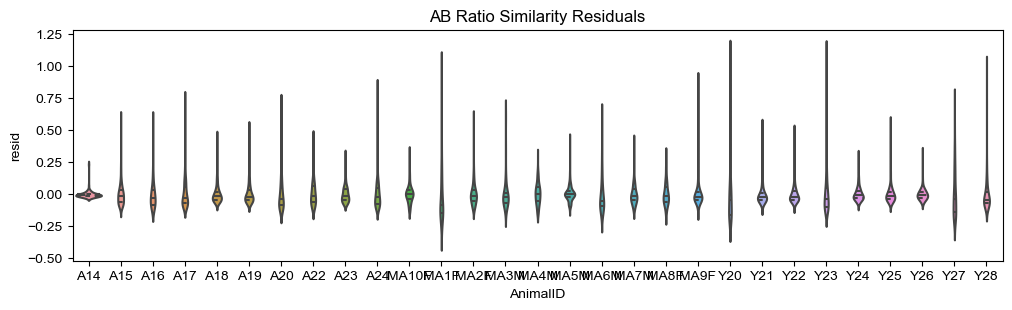

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     A_B_ratio
No. Observations:     8022        Method:                 REML     
No. Groups:           29          Scale:                  0.0030   
Min. group size:      88          Log-Likelihood:         8292.1848
Max. group size:      506         Converged:              Yes      
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.017    0.013 77.250 0.000  0.991  1.043
C(AgeGroup)[T.2.0]       -0.001    0.020 -0.032 0.975 -0.040  0.038
C(AgeGroup)[T.3.0]        0.054    0.016  3.366 0.001  0.022  0.085
C(Sex)[T.M]              -0.003    0.021 -0.133 0.894 -0.043  0.038
C(Cohort)[T.D]            0.016    0.026  0.635 0.525 -0.034  0

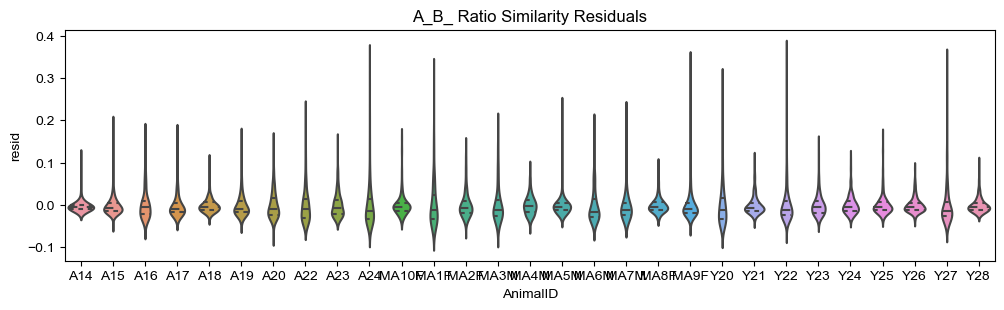

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     AB_ratio 
No. Observations:     8022        Method:                 REML     
No. Groups:           29          Scale:                  0.0036   
Min. group size:      88          Log-Likelihood:         7411.9742
Max. group size:      506         Converged:              Yes      
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.014    0.014 72.430 0.000  0.987  1.041
C(AgeGroup)[T.2.0]        0.010    0.021  0.473 0.636 -0.031  0.052
C(AgeGroup)[T.3.0]        0.044    0.017  2.604 0.009  0.011  0.078
C(Sex)[T.M]              -0.013    0.022 -0.570 0.569 -0.056  0.030
C(Cohort)[T.D]            0.015    0.027  0.535 0.592 -0.039  0

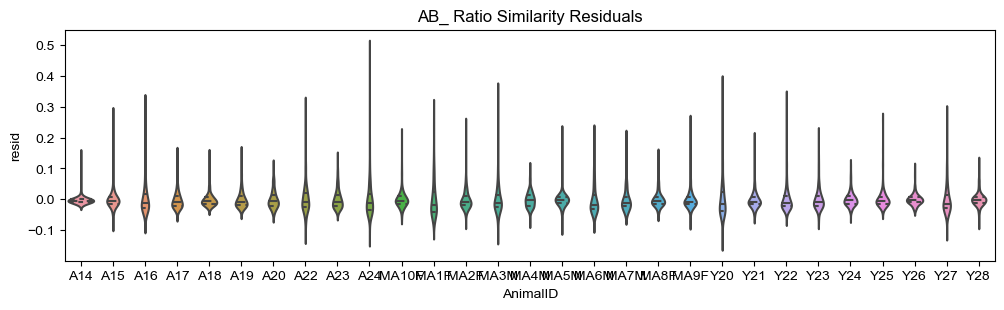

In [39]:
''' LMMs for Similarity Ratios '''        
#gather dependent variables into lists
ABratio = list(np.concatenate((aABratio, maABratio, yABratio)))
A_B_ratio = list(np.concatenate((aA_B_ratio, maA_B_ratio, yA_B_ratio)))
AB_ratio = list(np.concatenate((aAB_ratio, maAB_ratio, yAB_ratio)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, ABratio, A_B_ratio, AB_ratio))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','ABratio','A_B_ratio','AB_ratio'])

#handle NaNs
df = df.dropna(axis = 0)

# ABratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

#plot residuals
df['resid'] = mAB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB Ratio Similarity Residuals')
plt.show()

# A_B_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_B_.summary())
print(mA_B_.wald_test_terms(scalar = False))

df['resid'] = mA_B_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('A_B_ Ratio Similarity Residuals')
plt.show()

# AB_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB_.summary())
print(mAB_.wald_test_terms(scalar = False))

df['resid'] = mAB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB_ Ratio Similarity Residuals')
plt.show()

In [41]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mABfitted'] = mAB.fittedvalues
df['mAB_fitted'] = mAB_.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mABfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mABfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mAB_fitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for block ratio
10 10 8

n aged, MA, young mice on day 1 for alt ratio
10 10 8

n aged, MA, young mice on day 2 for block ratio
10 10 9

n aged, MA, young mice on day 2 for alt ratio
10 10 9

n aged, MA, young mice on day 3 for block ratio
9 10 9

n aged, MA, young mice on day 3 for alt ratio
9 10 9

n aged, MA, young mice on day 4 for block ratio
9 9 9

n aged, MA, young mice on day 4 for alt ratio
9 9 9

n aged, MA, young mice on day 5 for block ratio
8 9 9

n aged, MA, young mice on day 5 for alt ratio
8 9 9

n aged, MA, young mice on day 6 for block ratio
7 9 9

n aged, MA, young mice on day 6 for alt ratio
7 9 9


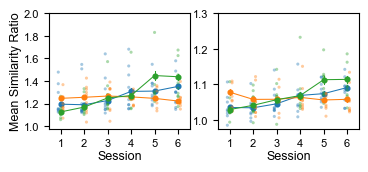

In [42]:
'''Plot Alt. Figure 2G (Mean Similarity Ratio)'''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)

g = sns.pointplot(x = df['Session'], y = mAB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([1,1.2,1.4,1.6,1.8,2])
ax[0].set_ylim([0.975,2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([1,1.1,1.2,1.3])
ax[1].set_ylim([0.975,1.3])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for block ratio')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for alt ratio')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure7B.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure7B.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.2891886017664681 0.45194240601644015 0.597207316637335 0.4147508900687554
P [Young, MA, Aged, All]: 
0.035708797563642446 0.00041699570241841085 2.352132408250855e-06 3.70452432736153e-08

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4889347628567832 0.5453635710924198 0.4418428398172184 0.4835378401567978
P [Young, MA, Aged, All]: 
0.00020331073207985177 1.1500806290380533e-05 0.0009256224818109322 6.22624399164585e-11

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4685896492700286 0.49161964197535957 0.6981469188021513 0.5251667732088185
P [Young, MA, Aged, All]: 
4.0667444578520516e-07 2.7856063625574683e-08 8.960024377934335e-17 1.65833092649975e-24

n session halves: young, ma, aged
106 114 106


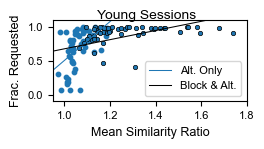

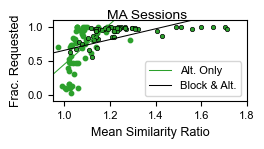

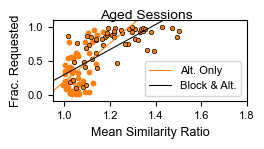

In [43]:
''' Plot Alternative Figure 2I with Block Data '''

#Linear regression with block data only
res = stats.linregress(sABratio[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[~np.isnan(sABratio)],reqblock_rates[~np.isnan(sABratio)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[~np.isnan(sAB_ratio)],reqalt_rates[~np.isnan(sAB_ratio)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindgrid],sAB_ratio[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindgrid],sAB_ratio[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindgrid],sAB_ratio[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))
res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure7D_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7D_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure7D_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7D_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure7D_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7D_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [44]:
''' Check Spearmann Correlations'''

allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.spearmanr(sABratio[y_sindgrid],reqblock_rates[y_sindgrid])
yr1 = res.statistic; yp1 = res.pvalue

res = stats.spearmanr(sABratio[ma_sindgrid],reqblock_rates[ma_sindgrid])
mar1 = res.statistic ; map1 = res.pvalue

res = stats.spearmanr(sABratio[age_sindgrid],reqblock_rates[age_sindgrid])
ar1 = res.statistic ; ap1 = res.pvalue

res = stats.spearmanr(sABratio[allidx],reqblock_rates[allidx])
allr1 = res.statistic; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.spearmanr(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid])
yr2 = res.statistic; yp2 = res.pvalue

res = stats.spearmanr(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid])
mar2 = res.statistic ; map2 = res.pvalue

res = stats.spearmanr(sAB_ratio[age_sindgrid],reqalt_rates[age_sindgrid])
ar2 = res.statistic ; ap2 = res.pvalue

res = stats.spearmanr(sAB_ratio[allidx],reqalt_rates[allidx])
allr2 = res.statistic; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.spearmanr(np.hstack((sABratio[y_sindgrid],sAB_ratio[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yr3 = res.statistic; yp3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[ma_sindgrid],sAB_ratio[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
mar3 = res.statistic ; map3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[age_sindgrid],sAB_ratio[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
ar3 = res.statistic ; ap3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allr3 = res.statistic; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4233170160183106 0.6398061782401598 0.6418070671286727 0.5501373800483756
P [Young, MA, Aged, All]: 
0.0015872532581720558 8.411717847399364e-08 2.229950018534587e-07 2.8130397573141057e-14

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5351511033710485 0.6687999707195665 0.25028742870444476 0.5244910593266494
P [Young, MA, Aged, All]: 
3.650471616409864e-05 1.3005387377767302e-08 0.07067487740251661 6.670846137597949e-13

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.6691790965680016 0.7019388571813088 0.731178250108892 0.6947125750592625
P [Young, MA, Aged, All]: 
4.476173139170287e-15 3.3127227086690012e-18 5.63352963001948e-19 2.75115730784393e-48


# NGS Cell Stability, Context-Matched Similarity, & Similarity Ratio

Figures S3i - n. You can skip to this session after setting up and loading in NGS cell booleans. 

In [45]:
''' Compute & Plot Sorted Cross-Trial Correlation Matrices for NGS Cells; Save Matrices for Later Use 

Run time is a few minutes per session (scales w/ NGS cell number).

'''

for m, session in zip(mice,sessions):

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)
        
        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
    
        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(ngscells)))
        for i, c in enumerate(ngscells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim
            
        # save matrix of cross-trial correlations
        d['allngssim'] = allsim
                               
        #allngssim_file = 'allbordersim_' + m + '_' + s + '_'+ '.npy'
        #np.save(save_folder + allngssim_file, allsim)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [46]:
''' Calculate Local Cross Trial Correlation Stability within Each Context & for Block vs. Alt Phases'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

#adjust loading folder path to match output of cell above
slocstab5A = []
slocstab5B = []
slocstab5A_ = []
slocstab5B_ = []
slocstab5block = []
slocstab5alt = []

mlocstab5A = []
mlocstab5B = []
mlocstab5A_ = []
mlocstab5B_ = []
max_k = 5

#cell arrays
ylocstab5A = []
ylocstab5B = []
ylocstab5A_ = []
ylocstab5B_ = []
ylocstab5block = []
ylocstab5alt = []

malocstab5A = []
malocstab5B = []
malocstab5A_ = []
malocstab5B_ = []
malocstab5block = []
malocstab5alt = []

alocstab5A = []
alocstab5B = []
alocstab5A_ = []
alocstab5B_ = []
alocstab5block = []
alocstab5alt = []

blockstability = []

for m, session in zip(mice, sessions):
    
    m_locstab5A = []
    m_locstab5B = []
    m_locstab5A_ = []
    m_locstab5B_ = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]     
        trial = behaviorfil[:,2]
        
        #load the context lengths, exclude A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx']
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        #allngssim_file = 'allbordersim_' + m + '_' + s + '_'+ '.npy'
        #d['allngssim'] = np.load(save_folder + allngssim_file)
        allsim = d['allngssim']
        
        local_stabilityA = []
        local_stabilityB = []
        local_stabilityA_ = []
        local_stabilityB_ = []
        local_stabilityblock = [] 
        local_stabilityalt = []
        
        for i, c in enumerate(ngscells):
            
            #divide sim by context
            sim = allsim[:,:,i]
            simA = sim[:lengthA,:lengthA]
            simB = sim[lengthA:(lengthA + lengthB),lengthA:(lengthA + lengthB)]
            simblock = sim[:(lengthA + lengthB),:(lengthA + lengthB)]
            simalt = sim[(lengthA + lengthB):,(lengthA + lengthB):]
            simA_ = sim[(lengthA + lengthB):(lengthA + lengthB + lengthA_), (lengthA + lengthB):(lengthA + lengthB + lengthA_)]
            simB_ = sim[(lengthA + lengthB + lengtha_):(lengthA + lengthB + lengtha_ + lengthB_),(lengthA + lengthB + lengtha_):(lengthA + lengthB + lengtha_ + lengthB_)]
            
            # Context A local neighborhood 5 trials
            max_k = 5
            sum_k = np.zeros(simA.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simA, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simA, offset=k)
            local_stabilityA = np.append(local_stabilityA, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 1

            #Context B
            max_k = 5
            sum_k = np.zeros(simB.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simB, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simB, offset=k)
            local_stabilityB = np.append(local_stabilityB, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 2

            #Context A_
            max_k = 5
            sum_k = np.zeros(simA_.shape[0])
            
            if simA_.shape[0] <= 2*max_k:
                #print(m, s, simA_.shape[0], simB_.shape[0])
                max_k = simA_.shape[0]//2
                max_k = 3
                
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simA_, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simA_, offset=k)
                    
            local_stabilityA_ = np.append(local_stabilityA_, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 3
            
            #Context B_
            if simB_.shape[0] <= 10:
                print('keeping lower max k for B_...' + str(max_k))
            else: 
                max_k = 5
                
            sum_k = np.zeros(simB_.shape[0])
            
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simB_, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simB_, offset=k)
                    
            local_stabilityB_ = np.append(local_stabilityB_, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 3
            
            #Block Stability
            max_k = 5  
            sum_k = np.zeros(simblock.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simblock, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simblock, offset=k)
            local_stabilityblock = np.append(local_stabilityblock, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
            #Alt Stability
            max_k = 5  
            sum_k = np.zeros(simalt.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simalt, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simalt, offset=k)
            local_stabilityalt = np.append(local_stabilityalt, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
        #save session results
        slocstab5A = np.append(slocstab5A, np.nanmean(local_stabilityA))
        m_locstab5A = np.append(m_locstab5A, local_stabilityA)
        slocstab5B = np.append(slocstab5B, np.nanmean(local_stabilityB))
        m_locstab5B = np.append(m_locstab5B, local_stabilityB)
        slocstab5A_ = np.append(slocstab5A_, np.nanmean(local_stabilityA_))
        m_locstab5A_ = np.append(m_locstab5A_, local_stabilityA_)    
        slocstab5B_ = np.append(slocstab5B_, np.nanmean(local_stabilityB_))
        m_locstab5B_ = np.append(m_locstab5B_, local_stabilityB_)
        
        slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
        slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))
        
        #pool by age group
        if m in SM_aged_mice:
            alocstab5A = np.append(alocstab5A, local_stabilityA) 
            alocstab5B = np.append(alocstab5B, local_stabilityB) 
            alocstab5A_ = np.append(alocstab5A_, local_stabilityA_) 
            alocstab5B_ = np.append(alocstab5B_, local_stabilityB_) 
            alocstab5block = np.append(alocstab5block, local_stabilityblock) 
            alocstab5alt = np.append(alocstab5alt, local_stabilityalt) 
        elif m in SM_MA_mice:
            malocstab5A = np.append(malocstab5A, local_stabilityA) 
            malocstab5B = np.append(malocstab5B, local_stabilityB) 
            malocstab5A_ = np.append(malocstab5A_, local_stabilityA_) 
            malocstab5B_ = np.append(malocstab5B_, local_stabilityB_) 
            malocstab5block = np.append(malocstab5block, local_stabilityblock) 
            malocstab5alt = np.append(malocstab5alt, local_stabilityalt) 
        else:
            ylocstab5A = np.append(ylocstab5A, local_stabilityA) 
            ylocstab5B = np.append(ylocstab5B, local_stabilityB) 
            ylocstab5A_ = np.append(ylocstab5A_, local_stabilityA_) 
            ylocstab5B_ = np.append(ylocstab5B_, local_stabilityB_) 
            ylocstab5block = np.append(ylocstab5block, local_stabilityblock) 
            ylocstab5alt = np.append(ylocstab5alt, local_stabilityalt) 
            
    #pool by animal
    mlocstab5A = np.append(mlocstab5A, np.nanmean(m_locstab5A))
    mlocstab5B = np.append(mlocstab5B, np.nanmean(m_locstab5B))
    mlocstab5A_ = np.append(mlocstab5A_, np.nanmean(m_locstab5A_))
    mlocstab5B_ = np.append(mlocstab5B_, np.nanmean(m_locstab5B_))

#save arrays
slocstab5A = np.asarray(slocstab5A)
slocstab5B = np.asarray(slocstab5B)
slocstab5A_ = np.asarray(slocstab5A_)
slocstab5B_ = np.asarray(slocstab5B_)
slocstab5block = np.asarray(slocstab5block)
slocstab5alt = np.asarray(slocstab5alt)

mlocstab5A = np.asarray(mlocstab5A)
mlocstab5B = np.asarray(mlocstab5B)
mlocstab5A_ = np.asarray(mlocstab5A_)
mlocstab5B_ = np.asarray(mlocstab5B_)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [47]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each NGS Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []
cengageA = []
cengageB = []
cengageA_ = []
cengageB_ = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        
        try:
            engagement_file = 'engagement_' + str(m) + '_' + str(s) + '.npy'
            blocknclickrate = np.load(engagement_folder + engagement_file)
        
        except: #if a session's behavioral data is not used for Figure 1/S1/S2, generate engagement data. 
            speed = raw.item().get('speed')
            posx = raw.item().get('posx')
            post = raw.item().get('post')
            lick_ct = d['reward_data']['lick_ct']
            trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
            reward = raw.item().get('reward')
            reward['trials'] = np.arange(0,len(reward['trials']),1)
            dt = np.unique(np.round(np.diff(post),4))
            if len(dt) > 1:
                dt = dt[dt != 0]

            # remove reward data pertaining to dark trials & skipped trials
            try:
                _ = raw.item().get('correctedtrial').shape
                skippedtrials = get.find_skipped(trial, max_trial_num = 220)
                nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
                k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
                keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)

            except:
                skippedtrials = []
                trial = raw.item().get('trial')
                keep_idx = (np.where(reward['trials'] > trials_dark))
                centers = np.array(reward['centers'][keep_idx])
                trials = np.array(reward['trials'][keep_idx])
                misses = reward['missed'][keep_idx].astype(bool)
                requests = ~misses 

            # get indices for reward zone (center ±25cm) & opp reward zone
            start_idx = []
            end_idx = [] 

            for t, c in zip(trials, centers):
                trial_pos = posx.copy()
                start_trial_ind = np.where(trial == t)[0][0]
                t_posx = trial_pos[trial == t]

                zone_start = c - 25 
                zone_end = c + 25

                if c == 270: 
                    oppzone_start = 370 - 25
                    oppzone_end = 370 + 25
                else: 
                    oppzone_start = 270 - 25
                    oppzone_end = 270 + 25

                s_idx = np.argmin(np.abs(t_posx - zone_start)) 
                st_idx = s_idx + start_trial_ind
                e_idx = np.argmin(np.abs(t_posx[s_idx:] - zone_end)) + st_idx

                start_idx.append(st_idx)
                end_idx.append(e_idx)

            start_idx = np.asarray(start_idx)
            end_idx = np.asarray(end_idx)

            # Remove any consummatory licks 
            nclick_ct = lick_ct.copy()
            for k in range(start_idx.shape[0]):
                st = start_idx[k]
                e = end_idx[k] + 1
                nclick_ct[st:e] = False

            # Get total nclicks/trial, save block & alternation mean for sessions, collect all values for animals
            nclickpertrial = []
            for t in trials:
                nclickpertrial = np.append(nclickpertrial, np.sum(nclick_ct[trial == t]))

            # Set up mean engagement array by context (A, B, A', B')
            blocknclickrate = []
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[trials < 81])) 
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[(trials >= 81) & (trials < 141)]))
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[(trials >= 141) & (centers == centers[0])]))
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[(trials >= 141) & (centers == centers[60])]))
        
        for j, c in enumerate(ngscells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            cengageA = np.append(cengageA, blocknclickrate[0])
            cengageB = np.append(cengageA, blocknclickrate[1])
            cengageA_ = np.append(cengageA, blocknclickrate[2])
            cengageB_ = np.append(cengageA, blocknclickrate[3])
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)
EngageA = list(cengageA)
EngageB = list(cengageB)
EngageA_ = list(cengageA_)
EngageB_ = list(cengageB_)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     locstab5A
No. Observations:     6662        Method:                 REML     
No. Groups:           29          Scale:                  0.0103   
Min. group size:      74          Log-Likelihood:         1197.3707
Max. group size:      427         Converged:              Yes      
Mean group size:      229.7                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.260    0.021 12.561 0.000  0.219  0.300
C(AgeGroup)[T.2.0]       -0.037    0.028 -1.306 0.191 -0.092  0.018
C(AgeGroup)[T.3.0]        0.068    0.024  2.805 0.005  0.020  0.115
C(Sex)[T.M]               0.043    0.027  1.585 0.113 -0.010  0.097
C(Cohort)[T.D]           -0.037    0.034 -1.085 0.278 -0.103  0

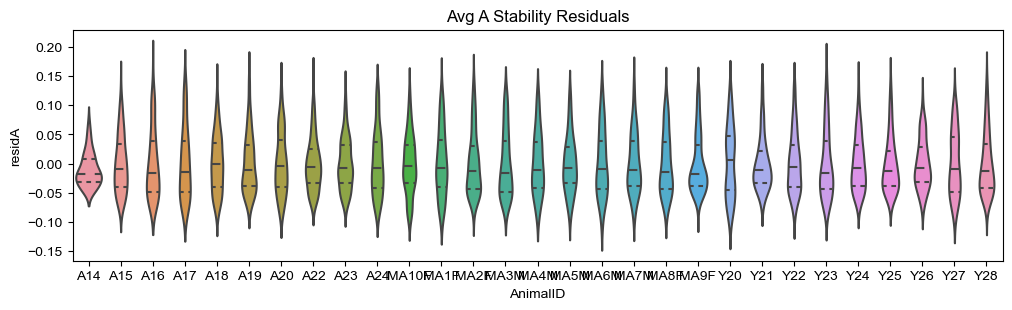

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     locstab5B
No. Observations:     6662        Method:                 REML     
No. Groups:           29          Scale:                  0.0091   
Min. group size:      74          Log-Likelihood:         1315.8900
Max. group size:      427         Converged:              No       
Mean group size:      229.7                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.227    0.026  8.839 0.000  0.177  0.277
C(AgeGroup)[T.2.0]       -0.004    0.037 -0.108 0.914 -0.076  0.068
C(AgeGroup)[T.3.0]        0.037    0.030  1.217 0.224 -0.022  0.095
C(Sex)[T.M]               0.018    0.037  0.498 0.619 -0.054  0.091
C(Cohort)[T.D]           -0.003    0.046 -0.066 0.947 -0.093  0

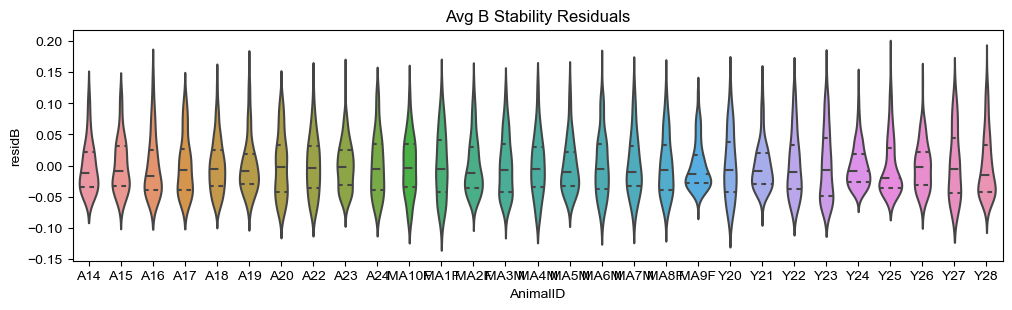

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    locstab5A_
No. Observations:      6662       Method:                REML      
No. Groups:            29         Scale:                 0.0098    
Min. group size:       74         Log-Likelihood:        2719.0730 
Max. group size:       427        Converged:             Yes       
Mean group size:       229.7                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.109    0.021  5.065 0.000  0.067  0.151
C(AgeGroup)[T.2.0]       -0.048    0.031 -1.567 0.117 -0.108  0.012
C(AgeGroup)[T.3.0]        0.078    0.025  3.103 0.002  0.029  0.127
C(Sex)[T.M]               0.022    0.031  0.704 0.481 -0.039  0.083
C(Cohort)[T.D]           -0.010    0.039 -0.268 0.788 -0.086  0

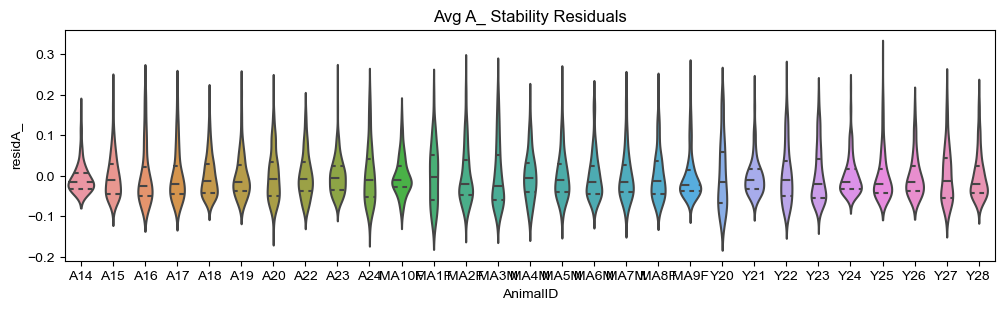

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    locstab5B_
No. Observations:      6662       Method:                REML      
No. Groups:            29         Scale:                 0.0091    
Min. group size:       74         Log-Likelihood:        2920.2389 
Max. group size:       427        Converged:             Yes       
Mean group size:       229.7                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.094    0.020  4.715 0.000  0.055  0.133
C(AgeGroup)[T.2.0]       -0.009    0.028 -0.305 0.760 -0.064  0.047
C(AgeGroup)[T.3.0]        0.063    0.023  2.696 0.007  0.017  0.109
C(Sex)[T.M]               0.032    0.029  1.129 0.259 -0.024  0.089
C(Cohort)[T.D]           -0.004    0.036 -0.114 0.909 -0.074  0

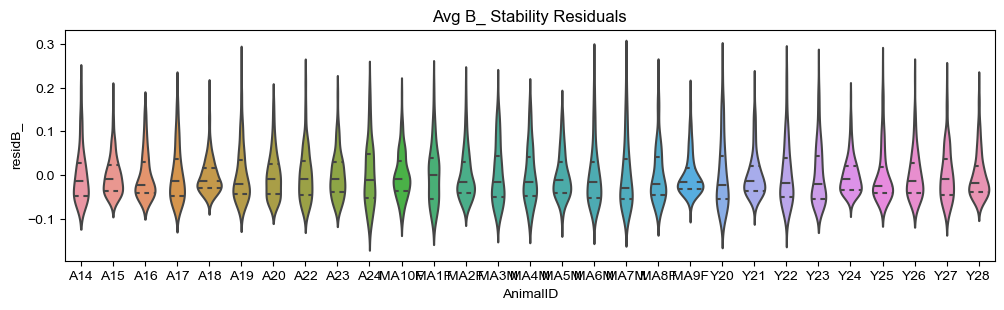

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   locstab5block
No. Observations:     6662      Method:               REML         
No. Groups:           29        Scale:                0.0115       
Min. group size:      74        Log-Likelihood:       2069.3474    
Max. group size:      427       Converged:            Yes          
Mean group size:      229.7                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.227    0.019 11.678 0.000  0.189  0.265
C(AgeGroup)[T.2.0]       -0.025    0.029 -0.874 0.382 -0.082  0.031
C(AgeGroup)[T.3.0]        0.050    0.024  2.080 0.038  0.003  0.097
C(Sex)[T.M]               0.032    0.029  1.114 0.265 -0.024  0.088
C(Cohort)[T.D]           -0.025    0.036 -0.688 0.491 -0.094  0

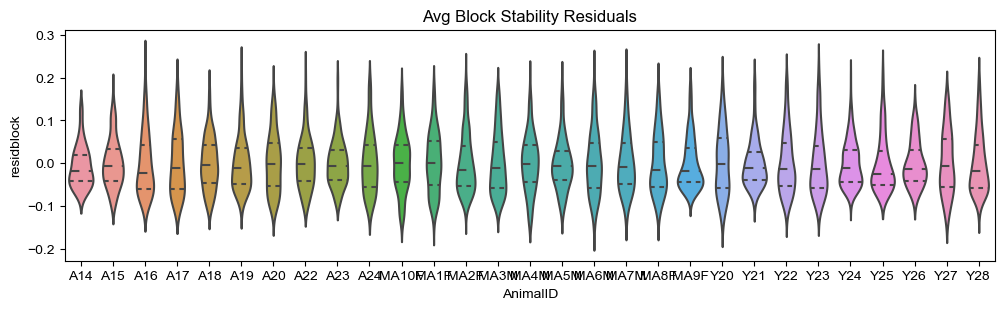

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    locstab5alt
No. Observations:     6662       Method:                REML       
No. Groups:           29         Scale:                 0.0064     
Min. group size:      74         Log-Likelihood:        4101.4272  
Max. group size:      427        Converged:             Yes        
Mean group size:      229.7                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.103    0.016  6.588 0.000  0.073  0.134
C(AgeGroup)[T.2.0]       -0.024    0.023 -1.006 0.314 -0.070  0.022
C(AgeGroup)[T.3.0]        0.049    0.019  2.552 0.011  0.011  0.087
C(Sex)[T.M]               0.019    0.024  0.791 0.429 -0.028  0.065
C(Cohort)[T.D]           -0.004    0.029 -0.125 0.900 -0.061  0

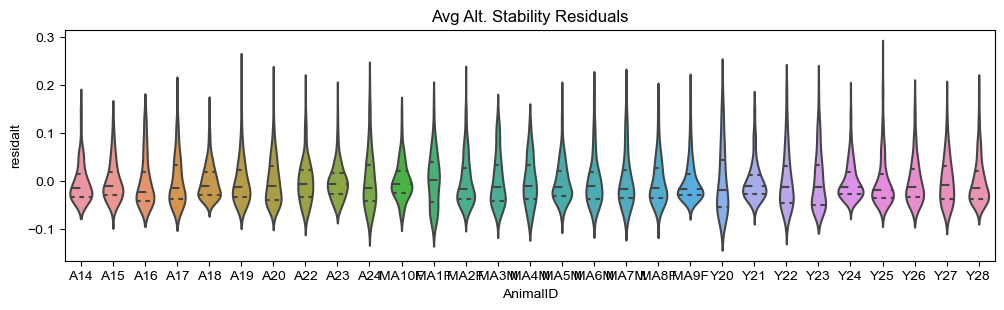

In [48]:
''' LMMs for NGS Cell Moving Avg Similarity [Stability] '''        
#gather dependent variables into lists
locstab5A = list(np.concatenate((alocstab5A, malocstab5A, ylocstab5A)))
locstab5B = list(np.concatenate((alocstab5B, malocstab5B, ylocstab5B)))
locstab5A_ = list(np.concatenate((alocstab5A_, malocstab5A_, ylocstab5A_)))
locstab5B_ = list(np.concatenate((alocstab5B_, malocstab5B_, ylocstab5B_)))
locstab5block = list(np.concatenate((alocstab5block, malocstab5block, ylocstab5block)))
locstab5alt = list(np.concatenate((alocstab5alt, malocstab5alt, ylocstab5alt)))
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, locstab5A, locstab5B, locstab5A_, locstab5B_,locstab5block,locstab5alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','locstab5A','locstab5B', 'locstab5A_', 'locstab5B_','locstab5block','locstab5alt'])

#handle NaNs
df = df.dropna(axis = 0)

#A Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA = smf.mixedlm('locstab5A ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA.summary())
print(mA.wald_test_terms(scalar = False))

df['residA'] = mA.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA', inner = 'quartile', ax = ax)
plt.title('Avg A Stability Residuals')
plt.show()

#B Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB = smf.mixedlm('locstab5B ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB.summary())
print(mB.wald_test_terms(scalar = False))

df['residB'] = mB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB', inner = 'quartile', ax = ax)
plt.title('Avg B Stability Residuals')
plt.show()

#A_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_ = smf.mixedlm('locstab5A_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_.summary())
print(mA_.wald_test_terms(scalar = False))

df['residA_'] = mA_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA_', inner = 'quartile', ax = ax)
plt.title('Avg A_ Stability Residuals')
plt.show()

#B_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB_ = smf.mixedlm('locstab5B_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB_.summary())
print(mB_.wald_test_terms(scalar = False))

df['residB_'] = mB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB_', inner = 'quartile', ax = ax)
plt.title('Avg B_ Stability Residuals')
plt.show()

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Stability Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. Stability Residuals')
plt.show()


In [49]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 9

n aged, MA, young mice on day 1 for B
10 10 9

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
10 10 9

n aged, MA, young mice on day 3 for B
10 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


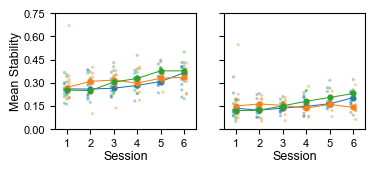

In [58]:
''' Composite Plot of Alternation Stability w/ Fitted Session Average Data Points (Figure 2f)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.15,0.3,0.45,0.6,0.75])
ax[0].set_ylim([0.0,0.75])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.15,0.3,0.45,0.6,0.75])
ax[1].set_ylim([0.0,0.75])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure7E.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure7E.svg', dpi=400, bbox_inches='tight')
plt.show()

In [51]:
''' Find where I will have NaNs'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

# This will fix session stats & box plots are plotted.

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55



Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.27937484170588717 0.5950326050362357 0.5272714994079923 0.43446899762414204
P [Young, MA, Aged, All]: 
0.04076878082722563 8.393100058089706e-07 3.532940918739259e-05 4.453634998518465e-09

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.19942485585472786 0.6177724175672445 0.42479151557571165 0.388767059764414
P [Young, MA, Aged, All]: 
0.14824885540366245 2.389879017609622e-07 0.0012268420044852977 2.0810288811815073e-07

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.46250340022343156 0.6413124859255908 0.656177487131741 0.5675174098805638
P [Young, MA, Aged, All]: 
4.671812996426054e-07 8.810264697980045e-15 7.17711137318804e-15 7.251299579004446e-30

n session halves: young, ma, aged
108 116 110


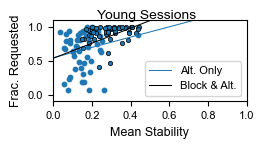

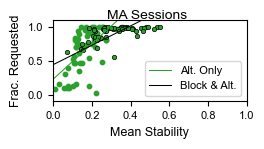

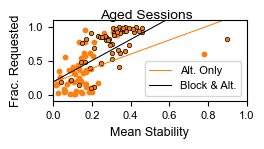

In [75]:
''' Plot Alternative Figure S3K with Block & Alt. Data '''
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindngs],reqblock_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindngs],reqblock_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindngs],reqblock_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[~np.isnan(slocstab5block)],reqblock_rates[~np.isnan(slocstab5block)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindngs],reqalt_rates[y_sindngs])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindngs],reqalt_rates[ma_sindngs])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindngs],reqalt_rates[age_sindngs])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[~np.isnan(slocstab5alt)],reqalt_rates[~np.isnan(slocstab5alt)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindngs],slocstab5alt[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindngs],slocstab5alt[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindngs],slocstab5alt[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))
res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindngs)*2,len(ma_sindngs)*2,len(age_sindngs)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure7G_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7G_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1.0])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure7G_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7G_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindngs],reqalt_rates[age_sindngs], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure7G_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7G_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [38]:
''' Check Spearmann Correlations'''

allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.spearmanr(slocstab5block[y_sindngs],reqblock_rates[y_sindngs])
yr1 = res.statistic; yp1 = res.pvalue

res = stats.spearmanr(slocstab5block[ma_sindngs],reqblock_rates[ma_sindngs])
mar1 = res.statistic ; map1 = res.pvalue

res = stats.spearmanr(slocstab5block[age_sindngs],reqblock_rates[age_sindngs])
ar1 = res.statistic ; ap1 = res.pvalue

res = stats.spearmanr(slocstab5block[allidx],reqblock_rates[allidx])
allr1 = res.statistic; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.spearmanr(slocstab5alt[y_sindngs],reqalt_rates[y_sindngs])
yr2 = res.statistic; yp2 = res.pvalue

res = stats.spearmanr(slocstab5alt[ma_sindngs],reqalt_rates[ma_sindngs])
mar2 = res.statistic ; map2 = res.pvalue

res = stats.spearmanr(slocstab5alt[age_sindngs],reqalt_rates[age_sindngs])
ar2 = res.statistic ; ap2 = res.pvalue

res = stats.spearmanr(slocstab5alt[allidx],reqalt_rates[allidx])
allr2 = res.statistic; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.spearmanr(np.hstack((slocstab5block[y_sindngs],slocstab5alt[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yr3 = res.statistic; yp3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[ma_sindngs],slocstab5alt[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
mar3 = res.statistic ; map3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[age_sindngs],slocstab5alt[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
ar3 = res.statistic ; ap3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allr3 = res.statistic; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3697889321403898 0.6156701092550869 0.6288303287179591 0.48465636922826844
P [Young, MA, Aged, All]: 
0.005921575739312123 2.6954090403181727e-07 2.7305172698055344e-07 3.207337249020505e-11

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.21670990314063257 0.6626000537397514 0.41637195815945965 0.4490858268043692
P [Young, MA, Aged, All]: 
0.11548914989065209 1.4644277967603832e-08 0.0015674581118590469 1.1485456755703555e-09

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5696354057582976 0.7299529039827805 0.7647951363530293 0.6601770795494525
P [Young, MA, Aged, All]: 
1.2454579482570545e-10 1.465624337710457e-20 2.385124520751546e-22 3.575129956328447e-43


In [59]:
''' Find Context Match / Mismatch Similarity Ratio '''

sABratio = []
sA_B_ratio = []
sAB_ratio = []

yABratio = []
yA_B_ratio = []
yAB_ratio = []
maABratio = []
maA_B_ratio = []
maAB_ratio = []
aABratio = []
aA_B_ratio = []
aAB_ratio = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]     
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allngssim = d['allngssim']
        ABratio = []
        A_B_ratio = []
        AB_ratio = []
        for i, c in enumerate(ngscells):
            sim = allngssim[:,:,i]
            sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))
            
            #average block context-matched (A x A + B x A), average block context-mismatched (B x A)
            sumcm = (np.sum(sim[:lengthA, :lengthA]) - lengthA)/2 + (np.sum(sim[lengthA:nB, lengthA:nB]) - lengthB)/2
            meancm = sumcm  / ((lengthA**2 - lengthA)/2 + (lengthB**2 - lengthB)/2)
            meancmm = np.average(sim[lengthA:nB,:lengthA])
            if (meancmm != 0): 
                ABratio = np.append(ABratio, meancm / meancmm)
            else: 
                ABratio = np.append(ABratio, np.nan)
            
            #alt context-matched (A' x A' + B' x B'), alt context-mismatched (B' x A')
            sumcm = (np.sum(sim[nB:nA_, nB:nA_]) - lengthA_)/2 + (np.sum(sim[na_:nB_, na_:nB_]) - lengthB_)/2
            meancm = sumcm  / ((lengthA_**2 - lengthA_)/2 + (lengthB_**2 - lengthB_)/2)
            meancmm = np.average(sim[na_:nB_,nB:nA_])
            if (meancmm != 0):
                A_B_ratio = np.append(A_B_ratio, meancm / meancmm)
            else:
                A_B_ratio = np.append(A_B_ratio, np.nan)
            
            #alt context-matched (A' x A + B' x B) & alt context-mismatched (B' x A + A' x B)
            meancm = np.mean(np.concatenate((sim[nB:nA_,:lengthA].flatten(), sim[na_:nB_,lengthA:nB].flatten())))
            meancmm = np.mean(np.concatenate((sim[na_:nB_,:lengthA].flatten(), sim[nB:nA_,lengthA:nB].flatten())))
            if (meancmm != 0):
                AB_ratio = np.append(AB_ratio, meancm / meancmm)
            else:
                AB_ratio = np.append(AB_ratio, np.nan)
        
        sABratio= np.append(sABratio, np.nanmean(ABratio))
        sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
        sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))

        if m in SM_aged_mice:
            aABratio = np.append(aABratio, ABratio)
            aA_B_ratio = np.append(aA_B_ratio, A_B_ratio)
            aAB_ratio = np.append(aAB_ratio, AB_ratio)
        elif m in SM_MA_mice:
            maABratio = np.append(maABratio, ABratio)
            maA_B_ratio = np.append(maA_B_ratio, A_B_ratio)
            maAB_ratio = np.append(maAB_ratio, AB_ratio)
        else:
            yABratio = np.append(yABratio, ABratio)
            yA_B_ratio = np.append(yA_B_ratio, A_B_ratio)
            yAB_ratio = np.append(yAB_ratio, AB_ratio)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     ABratio 
No. Observations:      6662        Method:                 REML    
No. Groups:            29          Scale:                  0.0116  
Min. group size:       74          Log-Likelihood:         812.6517
Max. group size:       427         Converged:              Yes     
Mean group size:       229.7                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.092    0.020 54.846 0.000  1.053  1.131
C(AgeGroup)[T.2.0]        0.013    0.029  0.434 0.664 -0.045  0.071
C(AgeGroup)[T.3.0]        0.056    0.025  2.225 0.026  0.007  0.105
C(Sex)[T.M]              -0.007    0.028 -0.233 0.815 -0.062  0.049
C(Cohort)[T.D]            0.021    0.035  0.608 0.543 -0.048  0

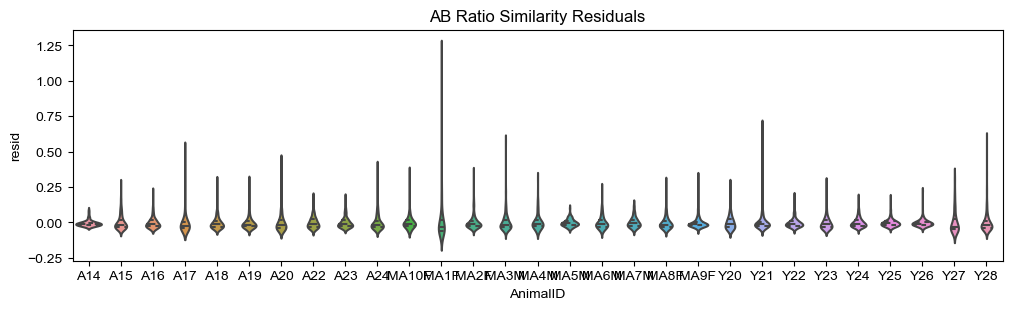

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     A_B_ratio
No. Observations:      6662        Method:                 REML     
No. Groups:            29          Scale:                  0.0017   
Min. group size:       74          Log-Likelihood:         7105.0893
Max. group size:       427         Converged:              Yes      
Mean group size:       229.7                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 1.018    0.009 111.167 0.000  1.000  1.036
C(AgeGroup)[T.2.0]        0.008    0.014   0.601 0.548 -0.019  0.035
C(AgeGroup)[T.3.0]        0.044    0.011   3.918 0.000  0.022  0.067
C(Sex)[T.M]              -0.007    0.014  -0.532 0.595 -0.034  0.019
C(Cohort)[T.D]            0.014    0.017   0.840 0

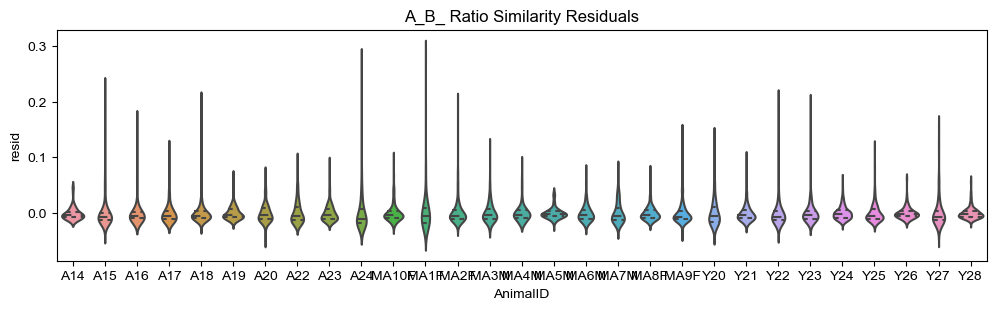

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     AB_ratio 
No. Observations:     6662        Method:                 REML     
No. Groups:           29          Scale:                  0.0018   
Min. group size:      74          Log-Likelihood:         6748.2401
Max. group size:      427         Converged:              Yes      
Mean group size:      229.7                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.019    0.011 90.523 0.000  0.997  1.041
C(AgeGroup)[T.2.0]        0.015    0.017  0.881 0.379 -0.018  0.048
C(AgeGroup)[T.3.0]        0.024    0.014  1.756 0.079 -0.003  0.051
C(Sex)[T.M]              -0.012    0.017 -0.681 0.496 -0.045  0.022
C(Cohort)[T.D]            0.013    0.021  0.613 0.540 -0.028  0

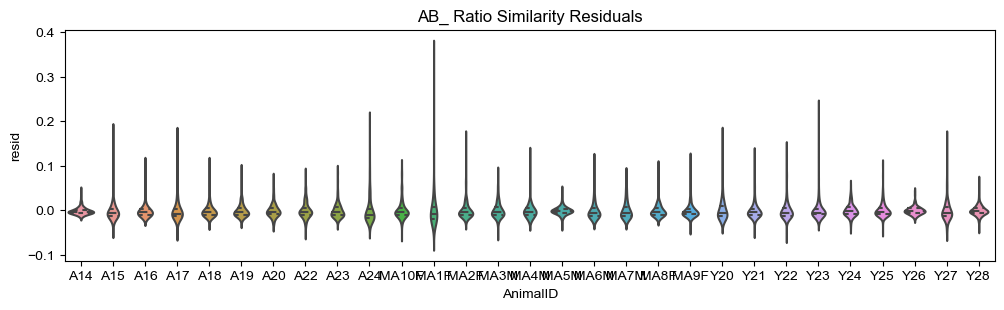

In [60]:
''' LMMs for Similarity Ratios '''        
#gather dependent variables into lists
ABratio = list(np.concatenate((aABratio, maABratio, yABratio)))
A_B_ratio = list(np.concatenate((aA_B_ratio, maA_B_ratio, yA_B_ratio)))
AB_ratio = list(np.concatenate((aAB_ratio, maAB_ratio, yAB_ratio)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, ABratio, A_B_ratio, AB_ratio))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','ABratio','A_B_ratio','AB_ratio'])

#handle NaNs
df = df.dropna(axis = 0)

# ABratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

#plot residuals
df['resid'] = mAB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB Ratio Similarity Residuals')
plt.show()

# A_B_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_B_.summary())
print(mA_B_.wald_test_terms(scalar = False))

df['resid'] = mA_B_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('A_B_ Ratio Similarity Residuals')
plt.show()

# AB_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB_.summary())
print(mAB_.wald_test_terms(scalar = False))

df['resid'] = mAB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB_ Ratio Similarity Residuals')
plt.show()

In [61]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mABfitted'] = mAB.fittedvalues
df['mAB_fitted'] = mAB_.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mABfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mABfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mAB_fitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for block ratio
10 10 9

n aged, MA, young mice on day 1 for alt ratio
10 10 9

n aged, MA, young mice on day 2 for block ratio
10 10 9

n aged, MA, young mice on day 2 for alt ratio
10 10 9

n aged, MA, young mice on day 3 for block ratio
10 10 9

n aged, MA, young mice on day 3 for alt ratio
10 10 9

n aged, MA, young mice on day 4 for block ratio
9 10 9

n aged, MA, young mice on day 4 for alt ratio
9 10 9

n aged, MA, young mice on day 5 for block ratio
8 9 9

n aged, MA, young mice on day 5 for alt ratio
8 9 9

n aged, MA, young mice on day 6 for block ratio
8 9 9

n aged, MA, young mice on day 6 for alt ratio
8 9 9


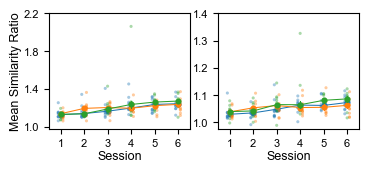

In [65]:
'''Plot Alt. Figure SJ (Mean Similarity Ratio)'''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)

g = sns.pointplot(x = df['Session'], y = mAB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([1,1.4,1.8,2.2])
ax[0].set_ylim([0.975,2.2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([1,1.1,1.2,1.3,1.4])
ax[1].set_ylim([0.975,1.4])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for block ratio')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for alt ratio')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure7F.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure7F.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3934136696779291 0.38644747911518873 0.6458729434951341 0.40793707817860425
P [Young, MA, Aged, All]: 
0.003250227080154366 0.002732069833186922 1.0101743073418157e-07 4.4487078881950066e-08

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5606055700066958 0.4651426543293986 0.49272936710746984 0.48215885997561414
P [Young, MA, Aged, All]: 
1.0397557587782441e-05 0.00023427173481316323 0.0001326072751197856 4.1800356531534015e-11

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5449998306479558 0.43881089613165175 0.7380211308301695 0.5283347562088074
P [Young, MA, Aged, All]: 
1.073081542498103e-09 8.340512528696697e-07 3.6497567126521196e-20 2.0812849617248953e-25

n session halves: young, ma, aged
108 116 110


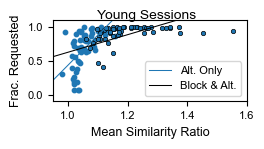

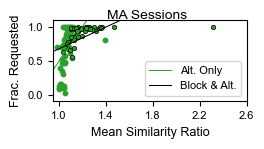

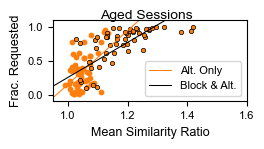

In [71]:
''' Plot Alternative Figure 2I with Block Data '''
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(sABratio[y_sindngs],reqblock_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindngs],reqblock_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindngs],reqblock_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindngs],reqalt_rates[age_sindngs])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindngs],sAB_ratio[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindngs],sAB_ratio[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindngs],sAB_ratio[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue; ap3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindngs)*2,len(ma_sindngs)*2,len(age_sindngs)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.6])
ax.set_xticks([1,1.2,1.4,1.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure7H_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7H_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,2.6])
ax.set_xticks([1,1.4,1.8,2.2,2.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure7H_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7H_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindngs],reqalt_rates[age_sindngs], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.6])
ax.set_xticks([1,1.2,1.4,1.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure7H_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure7H_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [72]:
''' Check Spearmann Correlations'''

allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.spearmanr(sABratio[y_sindngs],reqblock_rates[y_sindngs])
yr1 = res.statistic; yp1 = res.pvalue

res = stats.spearmanr(sABratio[ma_sindngs],reqblock_rates[ma_sindngs])
mar1 = res.statistic ; map1 = res.pvalue

res = stats.spearmanr(sABratio[age_sindngs],reqblock_rates[age_sindngs])
ar1 = res.statistic ; ap1 = res.pvalue

res = stats.spearmanr(sABratio[allidx],reqblock_rates[allidx])
allr1 = res.statistic; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.spearmanr(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs])
yr2 = res.statistic; yp2 = res.pvalue

res = stats.spearmanr(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs])
mar2 = res.statistic ; map2 = res.pvalue

res = stats.spearmanr(sAB_ratio[age_sindngs],reqalt_rates[age_sindngs])
ar2 = res.statistic ; ap2 = res.pvalue

res = stats.spearmanr(sAB_ratio[allidx],reqalt_rates[allidx])
allr2 = res.statistic; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.spearmanr(np.hstack((sABratio[y_sindngs],sAB_ratio[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yr3 = res.statistic; yp3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[ma_sindngs],sAB_ratio[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
mar3 = res.statistic ; map3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[age_sindngs],sAB_ratio[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
ar3 = res.statistic ; ap3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allr3 = res.statistic; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5931317533207814 0.6871229806567776 0.7479699094502086 0.6403829922577818
P [Young, MA, Aged, All]: 
2.287063435679247e-06 2.5788699345246876e-09 5.2904222130619335e-11 1.1809673301752588e-20

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.6061623474086743 0.6614290555980851 0.3640728105022945 0.5791268804865599
P [Young, MA, Aged, All]: 
1.188823031126425e-06 1.5846908227316717e-08 0.006285817524540398 2.435754513696778e-16

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.7344869265392824 0.6874147661494671 0.778393738723245 0.7249557459413957
P [Young, MA, Aged, All]: 
1.4843210238654074e-19 1.5706481346350265e-17 1.4237338700849242e-23 1.060559749102938e-55
